In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import math
import scipy.stats as stats
# from scipy.optimize import curve_fit

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import sklearn.preprocessing as prep
import sklearn.metrics as metrics
from sklearn import model_selection

from rfpimp import dropcol_importances
from rfpimp import importances

import pickle

c:\00_data\python38\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## Helper Functions

#### Helper functions for plotting

In [2]:
def plot_bar_diagram(ax, data, nested=False, plots_labels=None, plots_colors=None, bar_labels='', width=0.4, 
                     trend_line=False, trend_order=1, trend_color=None, 
                     title='', length_label='', tick_labels='', tick_axis_label='',
                     orient='v', legend_loc=None, spines=None):
    """
    Plots single or multiple bar diagrams with data labels on top(aside) of the bars
    :param ax: matplotlib axes
    :param data: pandas DataFrame where rows correspond to bar plots and columns correspond to data labels (columns in data)
    :param nested: boolean. If True, bar plots are plotted on top of each other. If False bar plots are plotted besides each other
    :param bar_labels: pandas DataFrame. labels over the bars. Should be same shape as data
    :param width: float. Bar width
    :param title: string. Plot title
    :param length_label: bar height/width axis label
    :param spines: dictionary of booleans. indicates to plot borders or not. Keys=['left', 'right', 'top', 'bottom'], values=True/False
    :param orient: string. Bar orientation: 'v'-vertical; 'h'-horisontal
    """
    bars = list(data.index)
    cols = list(data.columns)
    cells = data.values.tolist()

    if bar_labels is not None:
        labels = []
        for i, lab in enumerate(bars):
            if bar_labels=='':
                labels.append([f"{j:.4f}" for j in cells[i]])
            else:
                labels.append(bar_labels[i])
#             labels = ([f"{j:.4f}" for j in cells[i]] if bar_labels=='' else bar_labels[i])

    if orient == 'v':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            color = ('r' if plots_colors is None else plots_colors[i])
            x = np.arange(len(cols))
            bar = ax.bar(x=x + width * (i - len(bars) / 2), height=cells[i], width=width,
                         label=label,
                         color=color,
                         align=('center' if nested else 'edge'))
            
            if trend_line:
                trend_color = (color if trend_color is None else trend_color[i])
                _x = np.arange(len(cols))
                _y = cells[i]
                _z = np.polyfit(_x, _y, trend_order)
                _p = np.poly1d(_z)
                trend = ax.plot(_x, _p(_x), color=color, linestyle='--', linewidth=2.5)
            
            if bar_labels is not None:
                autolabel(bar, ax, labels[i], oriented='v')

        ax.set_xticks(np.arange(len(cols)))
        if tick_labels=='':
            ax.set_xticklabels(cols)
        else:
            ax.set_xticklabels(tick_labels)
        if not length_label=='':
            ax.set_ylabel(length_label, fontsize=12, fontweight='bold')
        if not tick_axis_label=='':
            ax.set_xlabel(tick_axis_label, fontsize=12, fontweight='bold')
    elif orient == 'h':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            y = np.arange(len(cols))
            height = width
            bar = ax.barh(y=y + height * (i - len(bars) / 2), width=cells[i], height=width,
                          label=label,
                          color=plots_colors[i],
                          align=('center' if nested else 'edge'))
            
            if trend_line:
                trend_color = (color if trend_color is None else trend_color[i])
                _x = np.arange(len(cols))
                _y = cells[i]
                _z = np.polyfit(_x, _y, trend_order)
                _p = np.poly1d(_z)
                trend = ax.plot(_x, _p(_x), color=color, linestyle='--', linewidth=2.5)
            
            if bar_labels is not None:
                autolabel(bar, ax, labels[i], oriented='v')
            if bar_labels is not None:
                autolabel(bar, ax, labels[i], oriented='h')

        ax.set_yticks(np.arange(len(cols)))
        if tick_labels=='':
            ax.set_yticklabels(cols)
        else:
            ax.set_yticklabels(tick_labels)
        if not length_label=='':
            ax.set_xlabel(length_label, fontsize=12, fontweight='bold')
        if not tick_axis_label=='':
            ax.set_ylabel(tick_axis_label, fontsize=12, fontweight='bold')
    else:
        raise ValueError('orient parameter value error. expected v or h ')

    if not title == '':
        ttl = ax.title
        ttl.set_position([.5, 1.07])
        ax.set_title(title, fontsize=14, fontweight='bold')
    if legend_loc is not None:
        ax.legend(loc=legend_loc)
    else:
        ax.legend().set_visible(False)

    if spines is None:
        spines = {'left': True,
                  'right': True,
                  'top': True,
                  'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])
        
    ax.grid(True, axis='y')

def autolabel(bars, ax, labels, oriented='v'):
    """Attach a text label displaying its height/width (depends of orientation)."""
    for bar, label in zip(bars, labels):
        if oriented == 'v':
            height = bar.get_height()
            ax.annotate(label,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),
                        textcoords="offset points",
                        ha='center')
        else:
            width = bar.get_width()
            ax.annotate(label,
                        xy=(width, bar.get_y() + bar.get_height() / 2),
                        xytext=(1, 0),
                        textcoords="offset points",
                        ha='left',
                        va='center')

def plot_correlation_matrix(ax, data, cmap='hot', diagonal=False, square=True, annotate=False, annot_kwargs=8):
    mask = None
    if diagonal:
        mask = np.zeros_like(data, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax,
                mask=mask,
                square=square,
                linewidths=1.5,
                cmap=cmap,
                cbar_kws={'shrink': 1, 'ticks': [-1, -.5, 0, 0.5, 1]},
                vmin=-1,
                vmax=1,
                annot=annotate,
                annot_kws={'size': annot_kwargs})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    
def plot_confusion_matrix(model, X, y, ax, normalize=True, title=None):
    """Plots confusion matrix
    Parameters:
    ax =  matplotlib axes
    normalyze = normalization over truth (number_predicted / total_count_of_this_class)
    """
    model.fit(X,y)
    conf_matrix = metrics.confusion_matrix(y_true=y, y_pred=model.predict(X),
                              labels=None)  # returns matrix for sorted classes (i.e 0, 1, 2,..., n)
    classes = y.unique()
    classes.sort()
    n_classes = [len(y[y == c]) for c in classes]
    if normalize == True:
        n_matrix = [[i for j in range(len(n_classes))] for i in n_classes]
        norm_matrix = conf_matrix / np.array(n_classes)
        ns_matrix = np.array([[i for j in enumerate(n_classes)] for i in n_classes])
        labels = np.array([["{0:.2%} \n {1:d} of {2:d}".format(norm_matrix[i, j], conf_matrix[i, j],
                                                               ns_matrix[i, j]) for j, v in
                            enumerate(norm_matrix[i])]
                           for i, v in enumerate(norm_matrix)])

        sns.heatmap(norm_matrix, annot=labels, fmt='', cmap='Blues')
    else:
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

    ax.set_ylabel('True Labels')
    ax.set_xlabel('Predicted Labels')
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title)
    ttl = ax.title
    ttl.set_position([.5, 1.07])

    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = ax.get_ylim()  # discover the values for bottom and top
    b += 0.5  # Add 0.5 to the bottom
    t -= 0.5  # Subtract 0.5 from the top
    ax.set_ylim(b, t)  # update the ylim(bottom, top) values
    
def plot_mae_deciles(model, X, y_true, y_bl, index, ax, log_transform=False, cumulative=False, title=None):
    y_pred = np.exp(model.predict(X)) - 1
    y_true = np.exp(y_true.values) - 1
    y_bl = np.exp(y_bl.values) - 1
    y_mae_model = np.abs(y_true - y_pred)
    y_mae_naive = np.abs(y_true - np.mean(y_bl))
    y = np.stack([y_mae_model, y_mae_naive], axis=1)
    y = pd.DataFrame(y, index=index, columns=['mae_model', 'mae_naive']).sort_values(by='mae_model', ascending=True)

    y_dec = np.zeros(len(y_true))
    n = len(y) // 10
    N = 10 * n
    for i in range(0, N, n):
        if i/n==9:
            y_dec[i:] = i/n
        else:
            y_dec[i:i+n] = i/n
    y['deciles'] = y_dec
    y['deciles'] = y['deciles'].astype('int32')

    mae_model = []
    mae_naive = []
    dec_labs = y['deciles'].unique()
    ax.set_xticks(np.arange(len(dec_labs)))
    for i in dec_labs:
        if cumulative:
            mae_model.append(np.mean(y.loc[y['deciles']<=i, 'mae_model']))
            mae_naive.append(np.mean(y.loc[y['deciles']<=i, 'mae_naive']))
            ax.set_xticklabels(np.arange(10,110,10))
            ax.set_xlabel('% of population')
            ax.set_ylabel('Mean absolute error \n (cumulative mean)')
        else:
            mae_model.append(np.mean(y.loc[y['deciles']==i, 'mae_model']))
            mae_naive.append(np.mean(y.loc[y['deciles']==i, 'mae_naive']))
            ax.set_xlabel('Deciles')
            ax.set_ylabel('Mean absolute error \n (mean per decile)')
    data = np.stack([mae_model, mae_naive], axis=1)
    data = pd.DataFrame(data, columns=['mae_model', 'mae_naive'])

    _x = data.index
    _y = data['mae_model'].values
    ax.plot(_x, _y, marker='o', color='b')
    
    _y = data['mae_naive']
    ax.plot(_x, _y, marker='o', color='r')
    
    ax.legend(['Model predictions', 'Naive predictions'])
    spines = {'left': True,
              'right': False,
              'top': False,
              'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])
        
    if log_transform:
        ax.set_yscale('log')
    
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title)
    ttl = ax.title
    ttl.set_position([.5, 1.05])
    
    ax.grid(True)
                 
    deciles = y['deciles']
    if index is not None:
        deciles.index = index
        
    return data, deciles

def plot_sale_change_deciles(model, X, y_true, y_bl, index, ax, cumulative=False, title=None, colors=None):
    y_pred = np.exp(model.predict(X)) - 1
    y_true = np.exp(y_true.values) - 1
    y_bl = np.exp(y_bl.values) - 1
    sale_change_pred = y_pred - y_bl
    sale_change_true = y_true - y_bl
    y = np.stack([sale_change_pred, sale_change_true], axis=1)
    y = pd.DataFrame(y, index=index, columns=['sale_change_pred', 'sale_change_true']).sort_values(by='sale_change_pred', ascending=False)

    y_dec = np.zeros(len(y_true))
    n = len(y) // 10
    N = 10 * n
    for i in range(0, N, n):
        if i/n==9:
            y_dec[i:] = i/n
        else:
            y_dec[i:i+n] = i/n
    y['deciles'] = y_dec
    y['deciles'] = y['deciles'].astype('int32')

    sale_change_pred = []
    sale_change_true = []
    dec_labs = y['deciles'].unique()
    ax.set_xticks(np.arange(len(dec_labs)))
    for i in dec_labs:
        if cumulative:
            sale_change_pred.append(np.mean(y.loc[y['deciles']<=i, 'sale_change_pred']))
            sale_change_true.append(np.mean(y.loc[y['deciles']<=i, 'sale_change_true']))
            ax.set_xticklabels(np.arange(10,110,10))
            ax.set_xlabel('% of population', fontsize=12, fontweight='bold')
            ax.set_ylabel('Sales change \n (mean per % of population)', fontsize=12, fontweight='bold')
        else:
            sale_change_pred.append(np.mean(y.loc[y['deciles']==i, 'sale_change_pred']))
            sale_change_true.append(np.mean(y.loc[y['deciles']==i, 'sale_change_true']))
            ax.set_xlabel('Deciles', fontsize=12, fontweight='bold')
            ax.set_ylabel('Sales change \n (mean per decile)', fontsize=12, fontweight='bold')
    data = np.stack([sale_change_pred, sale_change_true], axis=1)
    data = pd.DataFrame(data, columns=['sale_change_pred', 'sale_change_true'])

    _x = data.index
    _y = data['sale_change_pred'].values
    ax.plot(_x, _y, marker='o', color=('tab:blue' if colors is None else colors[0]))
    
    _y = data['sale_change_true']
    ax.plot(_x, _y, marker='o', color=('tab:orange' if colors is None else colors[0]))
    
    ax.legend(['Predicted sales change', 'True sales change'])
    spines = {'left': True,
              'right': False,
              'top': False,
              'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])
    
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title, fontsize=14, fontweight='bold')
    ttl = ax.title
    ttl.set_position([.5, 1.05])
    
    ax.grid(True)
                 
    deciles = y['deciles']
    if index is not None:
        deciles.index = index
        
    return data, deciles

def plot_sales_deciles(model, X, y_true, index, ax, cumulative=False, log_transform=False, title=None, colors=None):
    y_pred = np.exp(model.predict(X)) - 1
    y_true = np.exp(y_true.values) - 1
    y = np.stack([y_pred, y_true], axis=1)
    y = pd.DataFrame(y, index=index, columns=['sales_pred', 'sales_true']).sort_values(by='sales_pred', ascending=False)

    y_dec = np.zeros(len(y_true))
    n = len(y) // 10
    N = 10 * n
    for i in range(0, N, n):
        if i/n==9:
            y_dec[i:] = i/n
        else:
            y_dec[i:i+n] = i/n
    y['deciles'] = y_dec
    y['deciles'] = y['deciles'].astype('int32')

    sales_pred = []
    sales_true = []
    dec_labs = y['deciles'].unique()
    ax.set_xticks(np.arange(len(dec_labs)))
    for i in dec_labs:
        if cumulative:
            sales_pred.append(np.mean(y.loc[y['deciles']<=i, 'sales_pred']))
            sales_true.append(np.mean(y.loc[y['deciles']<=i, 'sales_true']))
            ax.set_xticklabels(np.arange(10,110,10))
            ax.set_xlabel('% of population', fontsize=12, fontweight='bold')
            ax.set_ylabel('Sales \n (mean per % of population)', fontsize=12, fontweight='bold')
        else:
            sales_pred.append(np.mean(y.loc[y['deciles']==i, 'sales_pred']))
            sales_true.append(np.mean(y.loc[y['deciles']==i, 'sales_true']))
            ax.set_xlabel('Deciles', fontsize=12, fontweight='bold')
            ax.set_ylabel('Sales \n (mean per decile)', fontsize=12, fontweight='bold')
    data = np.stack([sales_pred, sales_true], axis=1)
    data = pd.DataFrame(data, columns=['sales_pred', 'sales_true'])

    _x = data.index
    _y = data['sales_pred'].values
    ax.plot(_x, _y, marker='o', color=('tab:blue' if colors is None else colors[0]))
    
    _y = data['sales_true']
    ax.plot(_x, _y, marker='o', color=('tab:orange' if colors is None else colors[0]))
    
    if log_transform:
        ax.set_yscale('log')
    
    ax.legend(['Predicted sales', 'True sales'])
    spines = {'left': True,
              'right': False,
              'top': False,
              'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])
    
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title, fontsize=14, fontweight='bold')
    ttl = ax.title
    ttl.set_position([.5, 1.05])
    
    ax.grid(True)
                 
    deciles = y['deciles']
    if index is not None:
        deciles.index = index
        
    return data, deciles

def plot_deciles_data(data, figname='', color='dimgrey', plot_type='bar', trend_line=False, trend_order=1, trend_color='dimgrey', cumulative_pop=False, data_labels=False, x_label=None, y_label=None):
    grd = list(data.columns)
    grd_n = len(grd)
    grd_cols_n = 2
    grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

    plt_h = 4
    plt_w = 12
    
    fig_ttl = plt.figure()
    fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
    ax0 = fig_ttl.add_subplot()
    ax0.text(0.5, 0.5, figname, fontsize=18, horizontalalignment='center', verticalalignment='center')
    ax0.axis('off')

    fig = plt.figure()
    fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
    gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

    for idx, col in enumerate(list(data.columns)):
        if data_labels:
            labs = ['{0:.2f}'.format(i) for i in data[col]]
            bar_labels=[labs]
        else:
            bar_labels=None
        
        if cumulative_pop:
            tick_labels = np.arange(10,110,10)
        else:
            tick_labels = list(data.index)
        
        if x_label is not None:
            tick_axis_label = x_label
        else:
            tick_axis_label = ''
        if y_label is not None:
            length_label = y_label
        else:
            length_label = col
        
        if plot_type=='bar':
            plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                             data=data[col].to_frame().T,
                             bar_labels=bar_labels,
                             tick_labels = tick_labels,
                             plots_labels=None,
                             plots_colors=[color],
                             width=0.3,
                             trend_line=trend_line, 
                             trend_order=trend_order, 
                             trend_color=[trend_color],
                             title=None,
                             tick_axis_label=tick_axis_label,
                             length_label=length_label,
                             orient='v',
                             spines={'top': False, 'right': False})
        elif plot_type=='scatter':
            ax=fig.add_subplot(gs[idx])
            _x = tick_labels
            _y = data[col].values
            ax.scatter(_x, _y, marker='o', color=color)
            z = np.polyfit(_x, _y, 2)
            p = np.poly1d(z)
            ax.plot(_x, p(_x), color=color)
            
def plot_diagram_xy(data, x, y, ax, x_title=None, y_title=None, x_labels_format='{0:.2f}', title=None, pot_size=None):
    _data = data.copy()
    _data = _data.sort_values(by=x, ascending=False)
    _data['qcut'] = pd.cut(_data[x], 10, labels=False, duplicates='drop')

    cuts = _data['qcut'].unique()
    _x = np.zeros(len(cuts))
    _y = np.zeros(len(cuts))
    for idx, i in enumerate(cuts):
        _x[len(cuts)-1-idx] = np.mean(_data.loc[_data['qcut']==i, x])
        _y[len(cuts)-1-idx] = np.mean(_data.loc[_data['qcut']==i, y])
    plot_bar_diagram(ax=ax,
                     data=pd.Series(_y).to_frame().T,
                     tick_labels=[x_labels_format.format(i) for i in _x],
                     bar_labels=None,
                     orient='v',
                     width=0.3,
                     title=('{0} vs {1}'.format(y,x) if title is None else title),
                     length_label=(y if y_title is None else y_title),
                     tick_axis_label=(x if x_title is None else x_title),
                     plots_colors=['tab:blue'],
                     spines={'top': False, 'right': False})
    
def get_lift_chart(model, X, y_true, by_class=1):
    y_pred = np.exp(model.predict(X)) - 1
    y_true = np.exp(y_true.values) - 1
    y = np.stack([y_true, y_pred], axis=1)
    y = pd.DataFrame(y, columns=['true_y', 'predicted_y']).sort_values(by='true_y', ascending=False)
    y_dec = np.zeros(len(y_true))
    n = len(y) // 10
    N = 10 * n
    for i in range(0, N, n):
        if i/n==9:
            y_dec[i:] = i/n
        else:
            y_dec[i:i+n] = i/n
    y['deciles'] = y_dec
    y['deciles'] = y['deciles'].astype('int32')

    def p_cum_sum(arr_n, arr_p, pos):
        arr = []
        for i in range(pos + 1):
            arr.append(arr_p[i] * arr_n[i])
        return np.sum(arr)

    dec_labs = y['deciles'].unique()
    total_mean = np.mean(y['true_y'])
    n_samples = []
    dec_mean = []
    dec_lift_ovr_mean = []
    n_cum_samples = []
    cum_mean = []
    cum_lift_ovr_mean = []
    for i in dec_labs:
        dec_samples = y.loc[y['deciles']==i]

        n = len(dec_samples)
        p = np.mean(dec_samples['true_y'])
        lift_ovr = p / total_mean - 1

        n_samples.append(n)
        dec_mean.append(p)
        dec_lift_ovr_mean.append(lift_ovr)

        n_cum = len(y.loc[y['deciles']<=i])
        p_cum = (p if i==0 else p_cum_sum(n_samples, dec_mean, i) / n_cum)
        lift_ovr_cum = p_cum / total_mean - 1

        n_cum_samples.append(n_cum)
        cum_mean.append(p_cum)
        cum_lift_ovr_mean.append(lift_ovr_cum)
    lift = np.stack([n_samples, dec_mean, dec_lift_ovr_mean, n_cum_samples, cum_mean, cum_lift_ovr_mean], axis=1)
    return total_mean, pd.DataFrame(lift, columns=['n_samples', 'dec_mean', 'dec_lift_ovr_mean', 'n_cum_samples', 'cum_mean', 'cum_lift_ovr_mean'])

#### Helper functions for model training

In [3]:
# Tune parameters
def param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=''):
    if refit == '': refit = list(scoring.keys())[0]
    gsearch = model_selection.GridSearchCV(estimator=model, param_grid=param_ranges, scoring=scoring, cv=cv, refit=refit, return_train_score=True,
                           n_jobs=-1)
    gsearch.fit(X_train, y_train)
    cv_res = pd.DataFrame(gsearch.cv_results_)
    cv_res_sel = []
    for i in list(scoring.keys()):
        df = cv_res.loc[cv_res['rank_test_%s' % i] == 1].head(1)
        cv_res_sel.append(df[['mean_train_%s' % i, 'std_train_%s' % i, 'mean_test_%s' % i, 'std_test_%s' % i]].values[0])

    cv_res_sel = pd.DataFrame(cv_res_sel, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_res_sel.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return gsearch.best_estimator_, gsearch.best_params_, gsearch.best_score_, cv_results

# Cross-validation report
def cv_rep(model, X, y, cv, scoring, fit_params=None):
    cv_res = model_selection.cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=True, fit_params=fit_params, n_jobs=-1)
    cv_res = [[np.mean(cv_res['train_%s' % i]), np.std(cv_res['train_%s' % i]), np.mean(cv_res['test_%s' % i]), np.std(cv_res['test_%s' % i])] for i in list(scoring.keys())]
    cv_results = pd.DataFrame(cv_res, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_results.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return cv_results

# Tune model parameters and print CV report
def train_best_model(model, param_ranges, X_train, y_train, scoring, cv, refit):
    model, best_params, best_score, cv_res = param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print('CV results \n ===================================================')
    display(cv_res)
    print('\n Best parameters: ', best_params)
    return model, cv_res

# Tune model parameters and print CV report for calibrated classifier model
def train_best_model_cal(model, param_ranges, X_train, y_train, scoring, cv, refit):
    if model.__class__.__name__=='CalibratedClassifierCV':
         model_cal= model 
    else:
        model_cal = calib.CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv=cv)
    model_cal, best_params, best_score, cv_res = param_tune(model_cal, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

def dropcol_imp_r2_metric(model, X_valid, y_valid, sample_weights):
    y_pred = model.predict(X_valid)
    return metrics.r2_score(y_valid, y_pred, sample_weight=sample_weights)

#### Load data

In [4]:
data_2018 = pd.read_excel(io='Data/Transaction Data.xlsx',
                     sheet_name='Transactions18',
                     header=0,
                     index_col=0,
                     verbose=1)

Reading sheet Transactions18


In [5]:
data_2019 = pd.read_excel(io='Data/Transaction Data.xlsx',
                     sheet_name='Transactions19',
                     header=0,
                     index_col=0,
                     verbose=1)

Reading sheet Transactions19


#### Drop refresh date column

In [6]:
data_2018 = data_2018.drop(columns=['refresh_date'])

In [7]:
data_2019 = data_2019.drop(columns=['refresh_date'])

#### Add target columns

In [8]:
data_2019.columns = [i + '_target' for i in list(data_2019.columns)]

In [9]:
data_2019 = data_2019.loc[data_2018.index]

In [10]:
data = pd.concat([data_2018, data_2019], axis=1)

#### Deal with NaNs

All data is numeric and and naturaly is equal or more than zero. So will fill nans with zeros.

In [11]:
data = data.fillna(value=0)

#### Drop samples that have negative sales and positive redemptions

In [12]:
# Inspect positive variables
f_pos = ['sales_12M_target',
         'AUM', 
         'sales_curr',         
         'sales_12M',
         'aum_AC_EQUITY',
         'aum_AC_FIXED_INCOME_MUNI',
         'aum_AC_FIXED_INCOME_TAXABLE',
         'aum_AC_MULTIPLE',
         'aum_AC_PHYSICAL_COMMODITY',
         'aum_AC_REAL_ESTATE',
         'aum_AC_TARGET',
         'aum_P_529',
         'aum_P_ETF',
         'aum_P_MF',
         'aum_P_SMA',
         'aum_P_UCITS',
         'aum_P_UIT']

for i in f_pos:
    print(i, len(data.loc[data[i] < 0]))

sales_12M_target 2
AUM 4377
sales_curr 4
sales_12M 7
aum_AC_EQUITY 3871
aum_AC_FIXED_INCOME_MUNI 3276
aum_AC_FIXED_INCOME_TAXABLE 1694
aum_AC_MULTIPLE 1149
aum_AC_PHYSICAL_COMMODITY 90
aum_AC_REAL_ESTATE 3
aum_AC_TARGET 19
aum_P_529 14
aum_P_ETF 5
aum_P_MF 4564
aum_P_SMA 1151
aum_P_UCITS 15
aum_P_UIT 42


In [13]:
# Inspect negative variables
f_neg = ['redemption_curr',
'redemption_12M']

for i in f_neg:
    print(i, len(data.loc[data[i] > 0]))

redemption_curr 3
redemption_12M 4


In [14]:
data = data.loc[(data['sales_12M']>=0) & 
         (data['sales_12M_target']>=0) & 
         (data['sales_curr']>=0) & 
         (data['redemption_curr']<=0) & 
         (data['redemption_12M']<=0)]

#### Reverse redemptions sign

In [15]:
for i in f_neg:
    data[i] = data[i].apply(np.abs)

#### Add delta_sales = sales_12M_2019 - sales_12M_2018

In [16]:
data['delta_sales_12M_18_19'] = (data['sales_12M_target'] - data['sales_12M'])

#### Add net sales data (net_sales = sales - redumptions)

In [17]:
net_cols = {'net_no_of_sales_12M_1': ['no_of_sales_12M_1', 'no_of_Redemption_12M_1'], 
            'net_no_of_sales_12M_10K': ['no_of_sales_12M_10K', 'no_of_Redemption_12M_10K'], 
            'net_no_of_funds_sold_12M_1': ['no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1'], 
            'net_no_of_fund_sales_12M_10K': ['no_of_fund_sales_12M_10K', 'no_of_funds_Redemption_12M_10K'], 
            'net_no_of_assetclass_sold_12M_1': ['no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1'], 
            'net_no_of_assetclass_sales_12M_10K': ['no_of_assetclass_sales_12M_10K', 'no_of_assetclass_Redemption_12M_10K']}

In [18]:
for net_col in net_cols.keys():
    data[net_col] = data[net_cols[net_col][0]] - data[net_cols[net_col][1]]

In [19]:
data['net_sales_curr'] = data['sales_curr'] - data['redemption_curr']
data['net_sales_12M'] = data['sales_12M'] - data['redemption_12M']

#### Split aum columns into positive and negative columns

In [20]:
aum_cols = []
for i in list(data.columns):
    if 'aum' in i:
        aum_cols.append(i)

In [21]:
for aum_col in aum_cols:
    data['pos_' + aum_col] = data[aum_col].apply(lambda x: x if x >= 0 else 0)
    data['neg_' + aum_col] = data[aum_col].apply(lambda x: np.abs(x) if x < 0 else 0)

In [22]:
data['pos_AUM'] = data['AUM'].apply(lambda x: x if x >= 0 else 0)
data['neg_AUM'] = data['AUM'].apply(lambda x: np.abs(x) if x < 0 else 0)

#### Split net columns into positive and negative columns

In [23]:
for net_col in list(net_cols.keys()) + ['net_sales_curr', 'net_sales_12M']:
    data['pos_' + net_col] = data[net_col].apply(lambda x: x if x >= 0 else 0)
    data['neg_' + net_col] = data[net_col].apply(lambda x: np.abs(x) if x < 0 else 0)

#### Make a copy of data for post-processing

In [24]:
data_raw = data.copy()

#### Apply log-transform to continuous features

In [25]:
# Drop columns that have negative values
data = data.drop(columns=aum_cols)
data = data.drop(columns=['AUM'])
data = data.drop(columns=list(net_cols.keys()) + ['net_sales_curr', 'net_sales_12M'])

In [26]:
for i in ['sales_curr',
          'sales_12M',
          'redemption_curr',
          'redemption_12M',
          'pos_aum_AC_EQUITY',
          'neg_aum_AC_EQUITY',
          'pos_aum_AC_FIXED_INCOME_MUNI',
          'neg_aum_AC_FIXED_INCOME_MUNI',
          'pos_aum_AC_FIXED_INCOME_TAXABLE',
          'neg_aum_AC_FIXED_INCOME_TAXABLE',
          'pos_aum_AC_MONEY',
          'neg_aum_AC_MONEY',
          'pos_aum_AC_MULTIPLE',
          'neg_aum_AC_MULTIPLE',
          'pos_aum_AC_PHYSICAL_COMMODITY',
          'neg_aum_AC_PHYSICAL_COMMODITY',
          'pos_aum_AC_REAL_ESTATE',
          'neg_aum_AC_REAL_ESTATE',
          'pos_aum_AC_TARGET',
          'neg_aum_AC_TARGET',
          'pos_aum_P_529',
          'neg_aum_P_529',
          'pos_aum_P_ALT',
          'neg_aum_P_ALT',
          'pos_aum_P_CEF',
          'neg_aum_P_CEF',
          'pos_aum_P_ETF',
          'neg_aum_P_ETF',
          'pos_aum_P_MF',
          'neg_aum_P_MF',
          'pos_aum_P_SMA',
          'neg_aum_P_SMA',
          'pos_aum_P_UCITS',
          'neg_aum_P_UCITS',
          'pos_aum_P_UIT',
          'neg_aum_P_UIT',
          'pos_net_sales_curr',
          'pos_net_sales_12M',
          'neg_net_sales_curr',
          'neg_net_sales_12M']:
    data[i] = data[i].apply(lambda x: np.log(x+2))

#### Data summary

In [27]:
data_cols = ['sales_12M_target', 'new_Fund_added_12M_target']

In [28]:
for col in list(data.columns):
    if not col in data_cols:
        data_cols.append(col)

In [29]:
data = data[data_cols]

In [30]:
data_desc = data.describe().T
data_desc

count           mean           std  \
sales_12M_target                        9988.0  211519.205077  1.139872e+06   
new_Fund_added_12M_target               9988.0       0.432119  1.097845e+00   
no_of_sales_12M_1                       9988.0      20.049760  9.849246e+01   
no_of_Redemption_12M_1                  9988.0      20.966860  1.917042e+02   
no_of_sales_12M_10K                     9988.0       2.415098  1.452724e+01   
...                                        ...            ...           ...   
neg_net_no_of_assetclass_sales_12M_10K  9988.0       0.178815  4.544581e-01   
pos_net_sales_curr                      9988.0       1.933027  2.962739e+00   
neg_net_sales_curr                      9988.0       2.151050  3.268324e+00   
pos_net_sales_12M                       9988.0       3.514470  4.634025e+00   
neg_net_sales_12M                       9988.0       3.551015  4.390168e+00   

                                             min       25%        50%  \
sales_12M_target                        0.000000  0.000000  87.575000   
new_Fund_added_12M_target               0.000000  0.000000   0.000000   
no_of_sales_12M_1                       0.000000  0.000000   0.000000   
no_of_Redemption_12M_1                  0.000000  0.000000   1.000000   
no_of_sales_12M_10K                     0.000000  0.000000   0.000000   
...                                          ...       ...        ...   
neg_net_no_of_assetclass_sales_12M_10K  0.000000  0.000000   0.000000   
pos_net_sales_curr                      0.693147  0.693147   0.693147   
neg_net_sales_curr                      0.693147  0.693147   0.693147   
pos_net_sales_12M                       0.693147  0.693147   0.693147   
neg_net_sales_12M                       0.693147  0.693147   0.693147   

                                                 75%           max  
sales_12M_target                        45143.376250  4.867638e+07  
new_Fund_added_12M_target                   1.000000  2.000000e+01  
no_of_sales_12M_1                           8.000000  4.395000e+03  
no_of_Redemption_12M_1                      8.000000  1.215200e+04  
no_of_sales_12M_10K                         1.000000  9.860000e+02  
...                                              ...           ...  
neg_net_no_of_assetclass_sales_12M_10K      0.000000  4.000000e+00  
pos_net_sales_curr                          0.693147  1.608138e+01  
neg_net_sales_curr                          0.693147  1.620685e+01  
pos_net_sales_12M                           7.771091  1.697736e+01  
neg_net_sales_12M                           8.077702  1.704257e+01  

[72 rows x 8 columns]

#### Preselect features

In [31]:
# net_* features
x_net = []
for i in list(data.columns):
    if 'net' in i:
        x_net.append(i)

In [32]:
# aum_* features
x_aum = []
for i in list(data.columns):
    if 'aum' in i:
        x_aum.append(i)

In [33]:
# no_of*  features
x_noof = []
for i in list(data.columns):
    if (('no_of' in i) or ('No_of' in i)) & (i not in x_net):
        x_noof.append(i)

In [34]:
# no_of*  features
x_other = []
for i in list(data.columns):
    if (i not in x_net) & (i not in x_aum) & (i not in x_noof):
        x_other.append(i)

In [35]:
# Select a subset
x_sel = x_noof + x_aum + ['sales_curr', 'sales_12M', 'redemption_curr', 'redemption_12M', 'new_Fund_added_12M']

In [36]:
X_presel = data[x_sel]

In [37]:
target = 'sales_12M_target'

#### Check correlation

In [38]:
ds_target = data[target].values
corr_check = {}
p1 = []
p2 = []
p3 = []
for i in list(X_presel.columns):
    ds = X_presel[i].values
    # Pearson’s Correlation Coefficient
    _, p = stats.pearsonr(ds_target, ds)
    p1.append(p)
    # Spearman’s Rank Correlation
    _, p = stats.spearmanr(ds_target, ds)
    p2.append(p)
    # Kendall’s Rank Correlation
    _, p = stats.kendalltau(ds_target, ds)
    p3.append(p)
corr_check['pearson'] = p1
corr_check['sperman'] = p2
corr_check['kindall'] = p3

corr_check = pd.DataFrame(corr_check, index=list(X_presel.columns))

c:\00_data\python38\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\00_data\python38\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\00_data\python38\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\00_data\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\00_data\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\00_data\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [39]:
# A variable is considered to have a relationship with the target if p <= 0.05
corr_check = corr_check.applymap(lambda i: 1 if i <= 0.05 else 0)

In [40]:
corr_check['score'] = corr_check['pearson'] + corr_check['sperman'] + corr_check['kindall']

In [41]:
corr_check

pearson  sperman  kindall  score
no_of_sales_12M_1                          1        1        1      3
no_of_Redemption_12M_1                     1        1        1      3
no_of_sales_12M_10K                        1        1        1      3
no_of_Redemption_12M_10K                   1        1        1      3
no_of_funds_sold_12M_1                     1        1        1      3
no_of_funds_redeemed_12M_1                 1        1        1      3
no_of_fund_sales_12M_10K                   1        1        1      3
no_of_funds_Redemption_12M_10K             1        1        1      3
no_of_assetclass_sold_12M_1                1        1        1      3
no_of_assetclass_redeemed_12M_1            1        1        1      3
no_of_assetclass_sales_12M_10K             1        1        1      3
no_of_assetclass_Redemption_12M_10K        1        1        1      3
No_of_fund_curr                            1        1        1      3
No_of_asset_curr                           1        1        1      3
pos_aum_AC_EQUITY                          1        1        1      3
neg_aum_AC_EQUITY                          0        0        0      0
pos_aum_AC_FIXED_INCOME_MUNI               1        1        1      3
neg_aum_AC_FIXED_INCOME_MUNI               1        1        1      3
pos_aum_AC_FIXED_INCOME_TAXABLE            1        1        1      3
neg_aum_AC_FIXED_INCOME_TAXABLE            1        1        1      3
pos_aum_AC_MONEY                           0        0        0      0
neg_aum_AC_MONEY                           0        0        0      0
pos_aum_AC_MULTIPLE                        1        1        1      3
neg_aum_AC_MULTIPLE                        1        1        1      3
pos_aum_AC_PHYSICAL_COMMODITY              1        1        1      3
neg_aum_AC_PHYSICAL_COMMODITY              0        1        1      2
pos_aum_AC_REAL_ESTATE                     1        1        1      3
neg_aum_AC_REAL_ESTATE                     0        0        0      0
pos_aum_AC_TARGET                          1        1        1      3
neg_aum_AC_TARGET                          0        1        1      2
pos_aum_P_529                              0        1        1      2
neg_aum_P_529                              0        1        1      2
pos_aum_P_ALT                              1        0        0      1
neg_aum_P_ALT                              0        0        0      0
pos_aum_P_CEF                              1        1        1      3
neg_aum_P_CEF                              0        0        0      0
pos_aum_P_ETF                              1        1        1      3
neg_aum_P_ETF                              0        0        0      0
pos_aum_P_MF                               1        1        1      3
neg_aum_P_MF                               1        1        1      3
pos_aum_P_SMA                              1        1        1      3
neg_aum_P_SMA                              1        1        1      3
pos_aum_P_UCITS                            0        1        1      2
neg_aum_P_UCITS                            1        0        0      1
pos_aum_P_UIT                              0        1        1      2
neg_aum_P_UIT                              0        1        1      2
sales_curr                                 1        1        1      3
sales_12M                                  1        1        1      3
redemption_curr                            1        1        1      3
redemption_12M                             1        1        1      3
new_Fund_added_12M                         1        1        1      3

In [42]:
# Keep only features with the score >= 2
corr_check_cols = corr_check.loc[corr_check['score'] == 3].index

In [43]:
X_presel_corr = X_presel[corr_check_cols]

In [44]:
list(X_presel_corr.columns)

['no_of_sales_12M_1',
 'no_of_Redemption_12M_1',
 'no_of_sales_12M_10K',
 'no_of_Redemption_12M_10K',
 'no_of_funds_sold_12M_1',
 'no_of_funds_redeemed_12M_1',
 'no_of_fund_sales_12M_10K',
 'no_of_funds_Redemption_12M_10K',
 'no_of_assetclass_sold_12M_1',
 'no_of_assetclass_redeemed_12M_1',
 'no_of_assetclass_sales_12M_10K',
 'no_of_assetclass_Redemption_12M_10K',
 'No_of_fund_curr',
 'No_of_asset_curr',
 'pos_aum_AC_EQUITY',
 'pos_aum_AC_FIXED_INCOME_MUNI',
 'neg_aum_AC_FIXED_INCOME_MUNI',
 'pos_aum_AC_FIXED_INCOME_TAXABLE',
 'neg_aum_AC_FIXED_INCOME_TAXABLE',
 'pos_aum_AC_MULTIPLE',
 'neg_aum_AC_MULTIPLE',
 'pos_aum_AC_PHYSICAL_COMMODITY',
 'pos_aum_AC_REAL_ESTATE',
 'pos_aum_AC_TARGET',
 'pos_aum_P_CEF',
 'pos_aum_P_ETF',
 'pos_aum_P_MF',
 'neg_aum_P_MF',
 'pos_aum_P_SMA',
 'neg_aum_P_SMA',
 'sales_curr',
 'sales_12M',
 'redemption_curr',
 'redemption_12M',
 'new_Fund_added_12M']

#### Check for multicollinearity

In [45]:
X_presel_mcoll = add_constant(X_presel_corr)

In [46]:
vif = pd.Series([variance_inflation_factor(X_presel_mcoll.values, i) for i in range(X_presel_mcoll.shape[1])], index=X_presel_mcoll.columns)
vif

const                                  22.918463
no_of_sales_12M_1                       1.774009
no_of_Redemption_12M_1                  1.444390
no_of_sales_12M_10K                     4.094004
no_of_Redemption_12M_10K                3.738624
no_of_funds_sold_12M_1                 11.836301
no_of_funds_redeemed_12M_1              9.106615
no_of_fund_sales_12M_10K                8.315509
no_of_funds_Redemption_12M_10K          8.074715
no_of_assetclass_sold_12M_1            10.055318
no_of_assetclass_redeemed_12M_1         9.375699
no_of_assetclass_sales_12M_10K          6.530438
no_of_assetclass_Redemption_12M_10K     6.253593
No_of_fund_curr                         5.341963
No_of_asset_curr                       14.131532
pos_aum_AC_EQUITY                       4.290162
pos_aum_AC_FIXED_INCOME_MUNI            5.741883
neg_aum_AC_FIXED_INCOME_MUNI            2.125473
pos_aum_AC_FIXED_INCOME_TAXABLE         3.542619
neg_aum_AC_FIXED_INCOME_TAXABLE         1.335952
pos_aum_AC_MULTIPLE 

In [47]:
vif.pop('const')

22.918462578355992

In [48]:
X_presel_mcoll = X_presel_corr[vif.loc[vif < 5].index]

In [49]:
list(X_presel_mcoll.columns)

['no_of_sales_12M_1',
 'no_of_Redemption_12M_1',
 'no_of_sales_12M_10K',
 'no_of_Redemption_12M_10K',
 'pos_aum_AC_EQUITY',
 'neg_aum_AC_FIXED_INCOME_MUNI',
 'pos_aum_AC_FIXED_INCOME_TAXABLE',
 'neg_aum_AC_FIXED_INCOME_TAXABLE',
 'pos_aum_AC_MULTIPLE',
 'neg_aum_AC_MULTIPLE',
 'pos_aum_AC_PHYSICAL_COMMODITY',
 'pos_aum_AC_REAL_ESTATE',
 'pos_aum_AC_TARGET',
 'pos_aum_P_CEF',
 'pos_aum_P_ETF',
 'neg_aum_P_MF',
 'pos_aum_P_SMA',
 'neg_aum_P_SMA',
 'sales_curr',
 'redemption_curr',
 'new_Fund_added_12M']

#### Anomaly detection

In [50]:
# DBSCAN
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps = 0.8, metric='euclidean', min_samples=500, n_jobs=-1)
res = dbs.fit_predict(X_presel_mcoll)
res = pd.Series(res, index=X_presel_mcoll.index)
dbs_data = res.loc[res!=-1].index
dbs_noise = res.loc[res==-1].index

In [51]:
print(len(dbs_noise), ' outliers detected.')

9086  outliers detected.


In [52]:
X_presel_outl = X_presel_mcoll.loc[dbs_noise]
y_presel_outl = data.loc[dbs_noise, target].apply(lambda x: np.log(x+1))

In [53]:
print('Dataset length after outliers filtered: ', len(X_presel_outl))

Dataset length after outliers filtered:  9086


### Split data into train and test sets

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_presel_outl, y_presel_outl, test_size=0.3, random_state=30)

#### Define cross validation strategy

In [55]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold

random_state=30
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=random_state)
scoring = {'mae': 'neg_mean_absolute_error',
           'explained_variance':  'explained_variance',
           'r2': 'r2'}
refit='r2'

#### Define function for model validation on the test set

In [56]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def test_score(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print('\nValidation on the test set \n============================================')
    print('mean_absolute_error: ', mean_absolute_error(y_test, y_pred))
    print('explained_variance_score: ', explained_variance_score(y_test, y_pred))
    print('r2_score: ', r2_score(y_test, y_pred))

#### Initial model

In [57]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(loss='huber', 
                                criterion='friedman_mse',
                                learning_rate=0.1,
                                n_estimators=100,
                                random_state=random_state)
gbr = gbr.fit(X_train, y_train)
print('CV Results \n================================')
display(cv_rep(gbr, X_train, y_train, cv, scoring))
test_score(gbr, X_test, y_test)

CV Results 


mae  explained_variance        r2
mean_train  2.207898            0.642501  0.641211
std_train   0.024959            0.005219  0.005276
mean_test   2.362490            0.598390  0.596744
std_test    0.063948            0.022856  0.023132


Validation on the test set 
mean_absolute_error:  2.393461641149341
explained_variance_score:  0.5825111780287197
r2_score:  0.5824634994425928


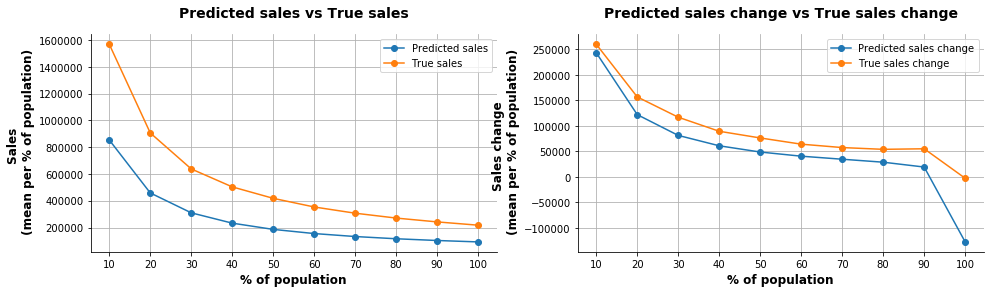

In [58]:
fig = plt.figure()
fig.set_size_inches(16, 4)
res_plot_s, deciles_s = plot_sales_deciles(gbr, X_test, y_test, index=X_test.index, 
                                     ax=fig.add_subplot(1,2,1), cumulative=True, log_transform=False, title='Predicted sales vs True sales')
res_plot_sch, deciles_sch = plot_sale_change_deciles(gbr, X_test, y_test, data.loc[X_test.index, 'sales_12M'], index=X_test.index, 
                                     ax=fig.add_subplot(1,2,2), cumulative=True, title='Predicted sales change vs True sales change')

In [59]:
res_plot_s.to_csv('Res_reg_x_noof_x_aum_others_03.csv')

#### Features importance

In [60]:
feature_importance_drop = dropcol_importances(gbr, X_train, y_train, X_valid=X_test, y_valid=y_test, metric=dropcol_imp_r2_metric)
feature_importance_premute = importances(gbr, X_valid=X_test, y_valid=y_test, metric=dropcol_imp_r2_metric)

In [61]:
feature_importance = feature_importance_drop.merge(feature_importance_premute, left_index=True, right_index=True)
feature_importance.columns = ['drop', 'premute']
feature_importance['sum'] = feature_importance['drop'] + feature_importance['premute']
feature_importance.sort_values(by='drop',ascending=False)

drop   premute       sum
Feature                                                      
sales_curr                       0.056292  0.343942  0.400233
redemption_curr                  0.005405  0.016543  0.021948
no_of_Redemption_12M_1           0.004925  0.021962  0.026888
no_of_sales_12M_10K              0.003073  0.021448  0.024521
pos_aum_AC_FIXED_INCOME_TAXABLE  0.001714  0.002702  0.004416
neg_aum_P_SMA                    0.001693 -0.000609  0.001084
neg_aum_AC_FIXED_INCOME_TAXABLE  0.001027 -0.000611  0.000416
pos_aum_AC_EQUITY                0.000890  0.000553  0.001443
no_of_Redemption_12M_10K         0.000825 -0.000470  0.000355
no_of_sales_12M_1                0.000576  0.157521  0.158096
pos_aum_AC_TARGET                0.000483  0.000000  0.000483
pos_aum_P_CEF                    0.000356 -0.000677 -0.000321
pos_aum_P_ETF                    0.000237  0.000034  0.000271
neg_aum_AC_MULTIPLE             -0.000014 -0.000849 -0.000862
pos_aum_AC_PHYSICAL_COMMODITY   -0.000134  0.000030 -0.000104
new_Fund_added_12M              -0.000632  0.002645  0.002013
pos_aum_AC_MULTIPLE             -0.000653 -0.000200 -0.000853
pos_aum_P_SMA                   -0.001013  0.001727  0.000713
neg_aum_P_MF                    -0.001065  0.000929 -0.000136
pos_aum_AC_REAL_ESTATE          -0.001136  0.000159 -0.000977
neg_aum_AC_FIXED_INCOME_MUNI    -0.001399 -0.000337 -0.001736

In [62]:
cols_imp_sorted = list(feature_importance['drop'].index)

In [63]:
important_cols = list(feature_importance.loc[feature_importance['drop'] > 0].index)

In [65]:
important_cols

['sales_curr',
 'redemption_curr',
 'no_of_Redemption_12M_1',
 'no_of_sales_12M_10K',
 'pos_aum_AC_FIXED_INCOME_TAXABLE',
 'neg_aum_P_SMA',
 'neg_aum_AC_FIXED_INCOME_TAXABLE',
 'pos_aum_AC_EQUITY',
 'no_of_Redemption_12M_10K',
 'no_of_sales_12M_1',
 'pos_aum_AC_TARGET',
 'pos_aum_P_CEF',
 'pos_aum_P_ETF']

In [66]:
X_presel_impcoll = X_presel_mcoll[important_cols]

In [67]:
X_presel_outl = X_presel_impcoll.loc[dbs_noise]
y_presel_outl = data.loc[dbs_noise, target].apply(lambda x: np.log(x+1))

### Split data into train and test sets

In [68]:
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_presel_outl, y_presel_outl, test_size=0.3, random_state=30)

In [69]:
from sklearn.ensemble import GradientBoostingRegressor
gbr1 = GradientBoostingRegressor(loss='huber', 
                                criterion='friedman_mse',
                                learning_rate=0.1,
                                n_estimators=100,
                                random_state=random_state)
gbr1 = gbr1.fit(X_train1, y_train1)
print('CV Results \n================================')
display(cv_rep(gbr1, X_train1, y_train1, cv, scoring))
test_score(gbr1, X_test1, y_test1)

CV Results 


mae  explained_variance        r2
mean_train  2.253700            0.634185  0.632711
std_train   0.026154            0.005408  0.005467
mean_test   2.389155            0.595501  0.593682
std_test    0.064844            0.023310  0.023634


Validation on the test set 
mean_absolute_error:  2.419445734427349
explained_variance_score:  0.5819876478478977
r2_score:  0.5819081454357539


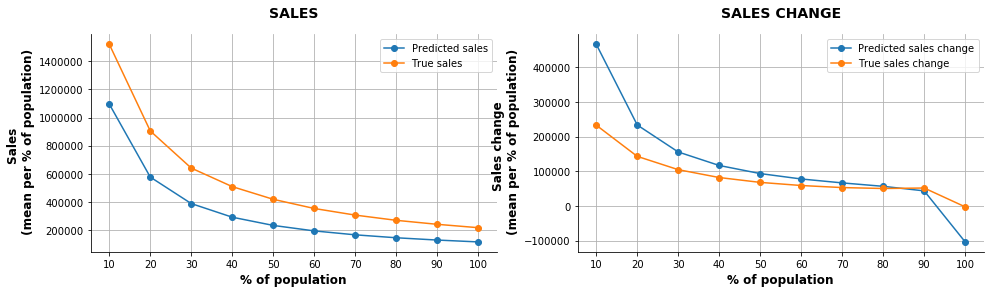

In [70]:
fig = plt.figure()
fig.set_size_inches(16, 4)
res_plot_s1, deciles_s1 = plot_sales_deciles(gbr1, X_test1, y_test1, index=X_test1.index, 
                                     ax=fig.add_subplot(1,2,1), cumulative=True, log_transform=False, title='SALES')
res_plot_sch1, deciles_sch1 = plot_sale_change_deciles(gbr1, X_test1, y_test1, data.loc[X_test1.index, 'sales_12M'], index=X_test1.index, 
                                     ax=fig.add_subplot(1,2,2), cumulative=True, title='SALES CHANGE')
plt.savefig('temp.jpg')

In [71]:
res_plot_s1.to_csv('Res1_reg_x_noof_x_aum_others_03.csv')

#### Compare models before and after feature importance study

In [72]:
x_noof_x_aum_others = pd.read_csv('Res_reg_x_noof_x_aum_others_03.csv', index_col=0)
x_noof_x_aum_others['delta'] = np.abs(x_noof_x_aum_others['sales_pred'] - x_noof_x_aum_others['sales_true'])

x_noof_x_aum_others_1 = pd.read_csv('Res1_reg_x_noof_x_aum_others_03.csv', index_col=0)
x_noof_x_aum_others_1['delta'] = np.abs(x_noof_x_aum_others_1['sales_pred'] - x_noof_x_aum_others_1['sales_true'])

In [73]:
res_data = x_noof_x_aum_others.copy()
res_data = res_data.drop(columns=['sales_pred', 'sales_true'])
res_data.columns = ['all_features']

In [74]:
res_data['important_features'] = x_noof_x_aum_others_1['delta']

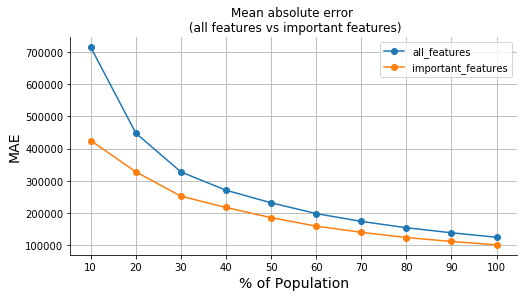

In [75]:
fig = plt.figure()
fig.set_size_inches(8, 4)
ax=fig.add_subplot(1,1,1)
x = np.arange(10,110,10)
colors = ['tab:blue', 'tab:orange']
for i, color in zip(list(res_data.columns), colors):
    y = res_data[i]
    ax.plot(x, y, marker='o', color=color)
    
ax.legend(list(res_data.columns))
spines = {'left': True,
          'right': False,
          'top': False,
          'bottom': True}
for i in list(spines.keys()):
    ax.spines[i].set_visible(spines[i])

ax.set_xticks(np.arange(10,110,10))
ax.set_xlabel('% of Population', fontsize=14)
ax.set_ylabel('MAE', fontsize=14)
ax.set_title('Mean absolute error \n (all features vs important features)')
ax.grid(True)
plt.savefig('temp.jpg')

### Results analysis

In [76]:
total_mean1, lift1 = get_lift_chart(gbr1, X_test1, y_test1, by_class=1)
print('Total mean: ', total_mean1, '\n')
lift1

Total mean:  217828.41166577 



n_samples      dec_mean  dec_lift_ovr_mean  n_cum_samples      cum_mean  \
0      272.0  1.949312e+06           7.948841          272.0  1.949312e+06   
1      272.0  1.749770e+05          -0.196721          544.0  1.062144e+06   
2      272.0  4.670359e+04          -0.785595          816.0  7.236642e+05   
3      272.0  1.082952e+04          -0.950284         1088.0  5.454555e+05   
4      272.0  1.267125e+03          -0.994183         1360.0  4.366178e+05   
5      272.0  0.000000e+00          -1.000000         1632.0  3.638482e+05   
6      272.0  0.000000e+00          -1.000000         1904.0  3.118699e+05   
7      272.0  0.000000e+00          -1.000000         2176.0  2.728861e+05   
8      272.0  0.000000e+00          -1.000000         2448.0  2.425655e+05   
9      278.0  0.000000e+00          -1.000000         2726.0  2.178284e+05   

   cum_lift_ovr_mean  
0           7.948841  
1           3.876060  
2           2.322175  
3           1.504060  
4           1.004412  
5           0.670343  
6           0.431723  
7           0.252757  
8           0.113562  
9           0.000000

In [77]:
lift1.to_csv('Sales_reg_lift1.csv')

In [78]:
important_cols

['sales_curr',
 'redemption_curr',
 'no_of_Redemption_12M_1',
 'no_of_sales_12M_10K',
 'pos_aum_AC_FIXED_INCOME_TAXABLE',
 'neg_aum_P_SMA',
 'neg_aum_AC_FIXED_INCOME_TAXABLE',
 'pos_aum_AC_EQUITY',
 'no_of_Redemption_12M_10K',
 'no_of_sales_12M_1',
 'pos_aum_AC_TARGET',
 'pos_aum_P_CEF',
 'pos_aum_P_ETF']

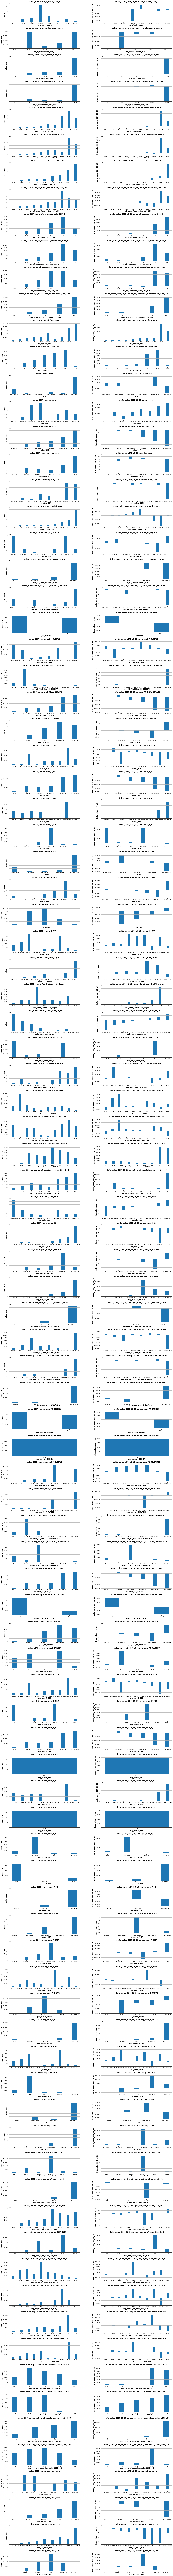

In [80]:
grd = data_raw.columns
grd_n = 2*len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

# fig_ttl = plt.figure()
# fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
# ax0 = fig_ttl.add_subplot()
# ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
# ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in zip(range(0, grd_n, 2), grd):
    plot_diagram_xy(data_raw, x=col, y='sales_12M', ax=fig.add_subplot(gs[idx]))
    plot_diagram_xy(data_raw, x=col, y='delta_sales_12M_18_19', ax=fig.add_subplot(gs[idx+1]))

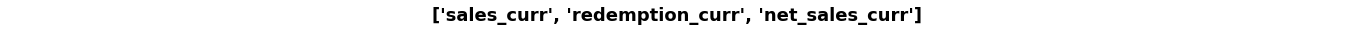

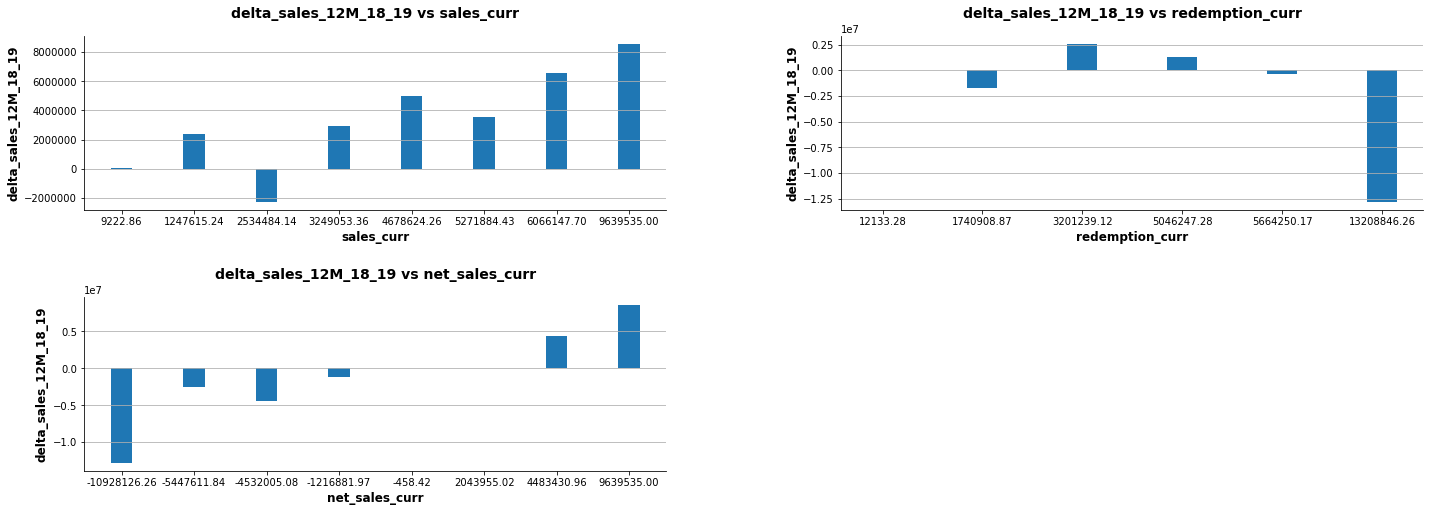

In [81]:
grd = ['sales_curr', 'redemption_curr', 'net_sales_curr']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data_raw, x=col, y='delta_sales_12M_18_19', ax=fig.add_subplot(gs[idx]))

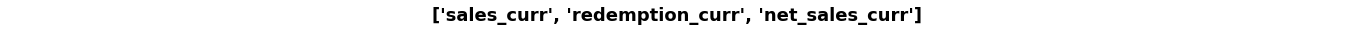

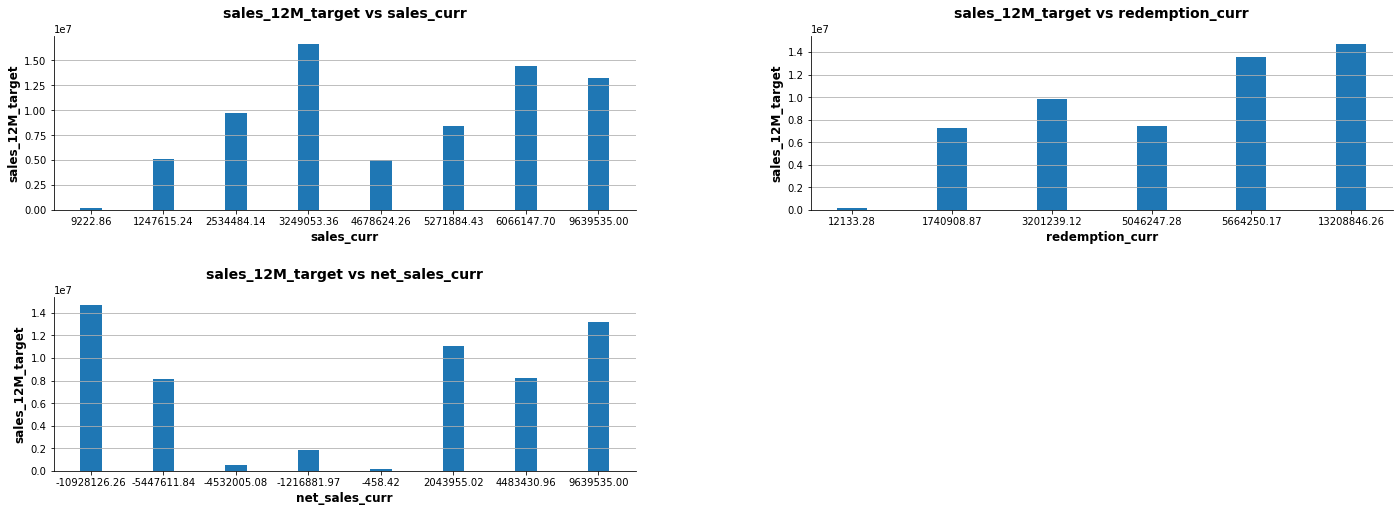

In [82]:
grd = ['sales_curr', 'redemption_curr', 'net_sales_curr']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data_raw, x=col, y='sales_12M_target', ax=fig.add_subplot(gs[idx]))

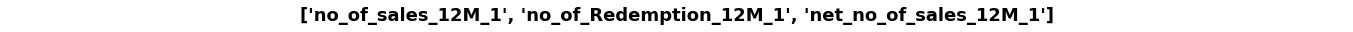

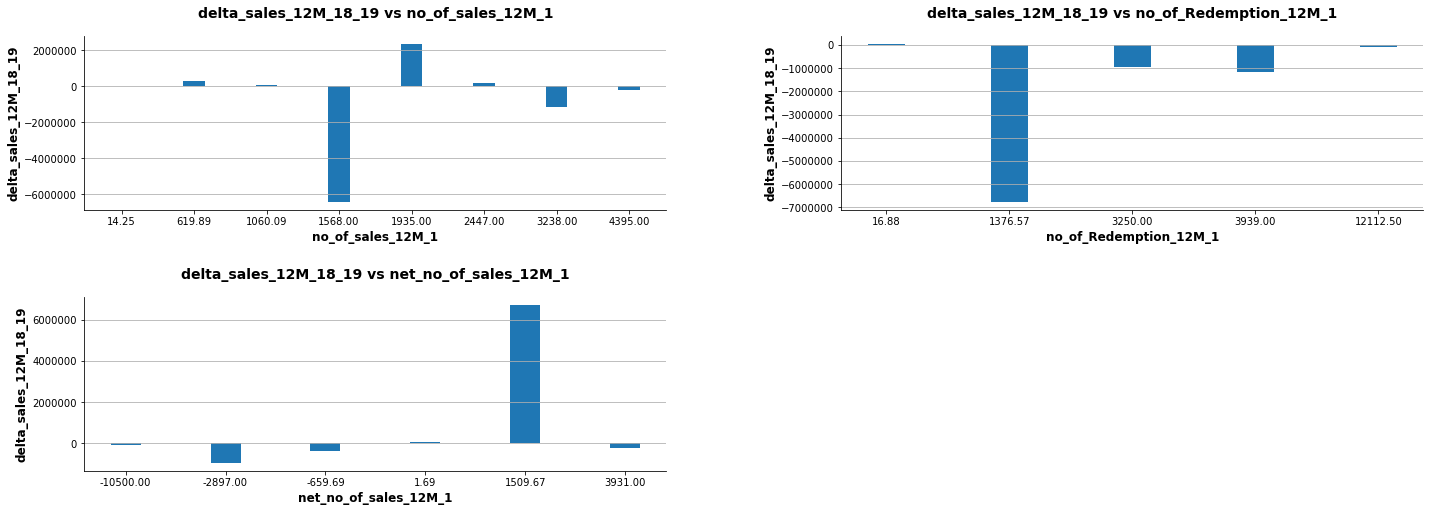

In [83]:
grd = ['no_of_sales_12M_1', 'no_of_Redemption_12M_1', 'net_no_of_sales_12M_1']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data_raw, x=col, y='delta_sales_12M_18_19', ax=fig.add_subplot(gs[idx]))

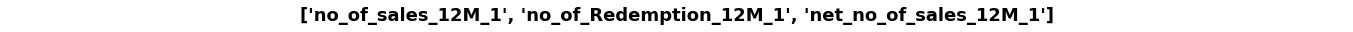

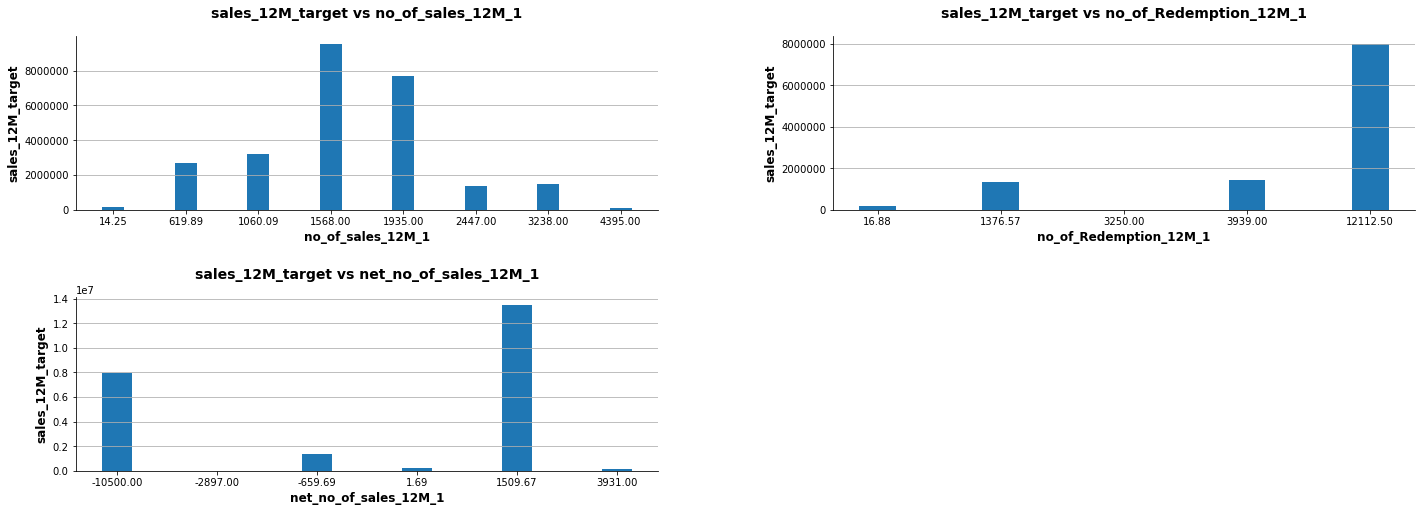

In [84]:
grd = ['no_of_sales_12M_1', 'no_of_Redemption_12M_1', 'net_no_of_sales_12M_1']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data_raw, x=col, y='sales_12M_target', ax=fig.add_subplot(gs[idx]))

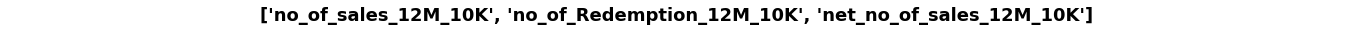

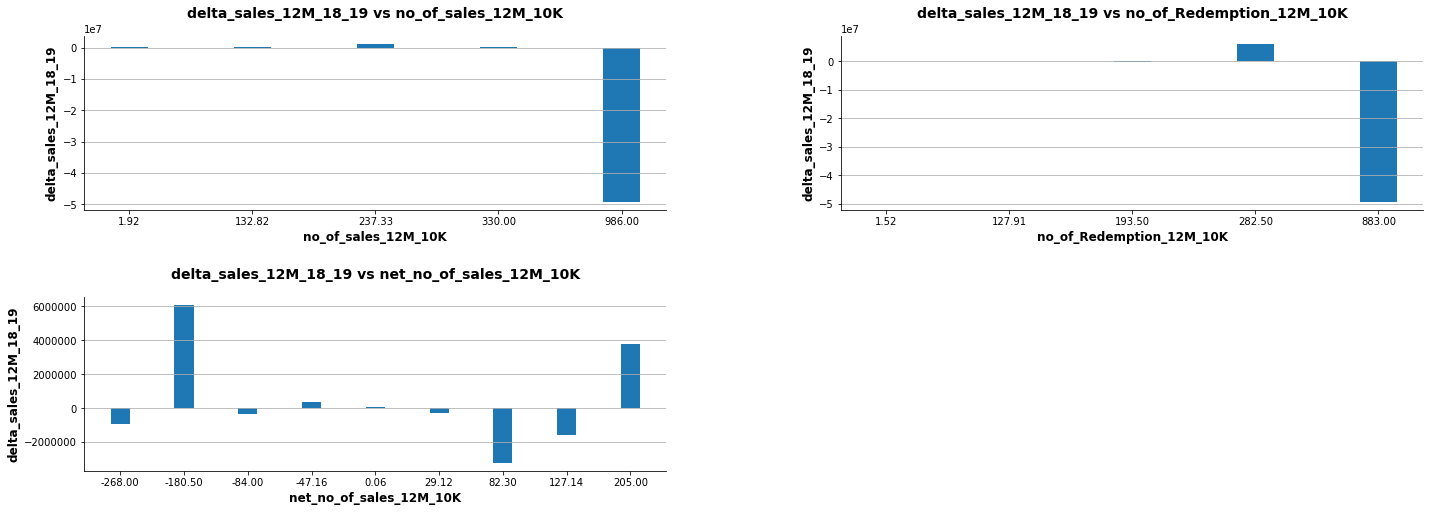

In [85]:
grd = ['no_of_sales_12M_10K', 'no_of_Redemption_12M_10K', 'net_no_of_sales_12M_10K']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data_raw, x=col, y='delta_sales_12M_18_19', ax=fig.add_subplot(gs[idx]))

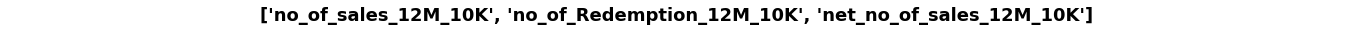

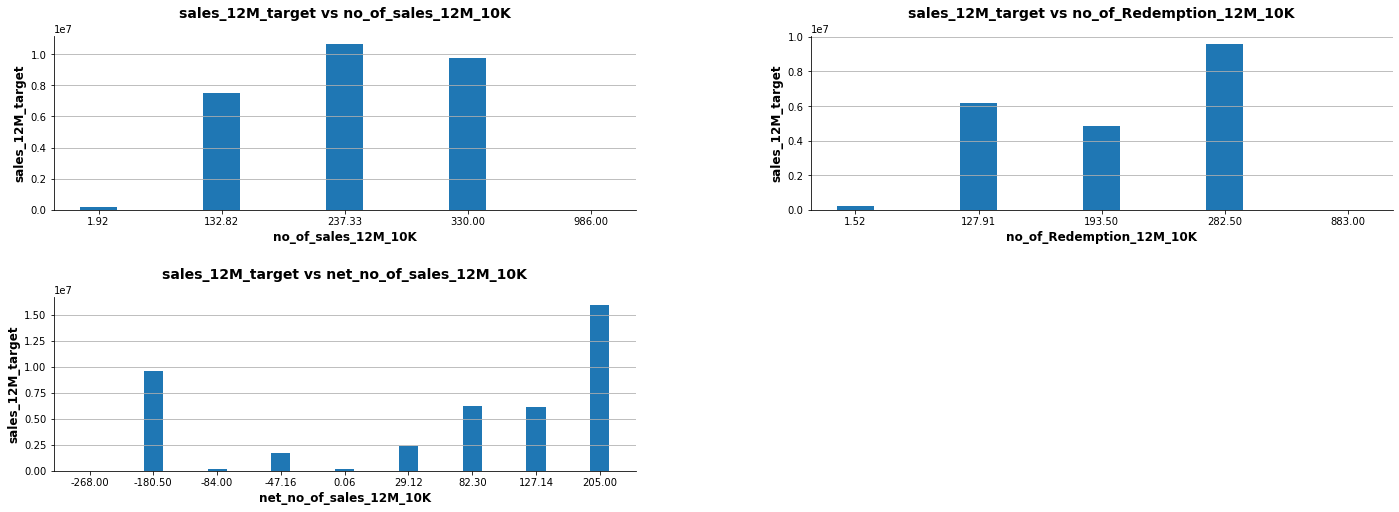

In [86]:
grd = ['no_of_sales_12M_10K', 'no_of_Redemption_12M_10K', 'net_no_of_sales_12M_10K']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data_raw, x=col, y='sales_12M_target', ax=fig.add_subplot(gs[idx]))

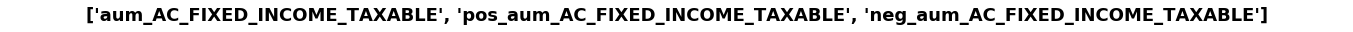

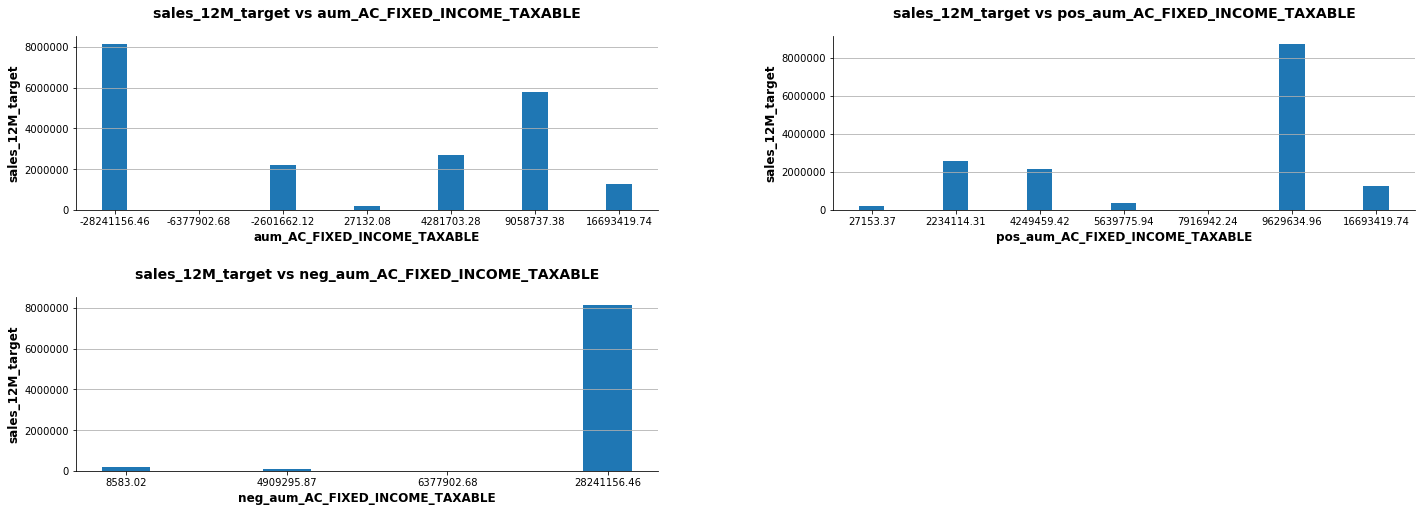

In [87]:
grd = ['aum_AC_FIXED_INCOME_TAXABLE', 'pos_aum_AC_FIXED_INCOME_TAXABLE', 'neg_aum_AC_FIXED_INCOME_TAXABLE']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data_raw, x=col, y='sales_12M_target', ax=fig.add_subplot(gs[idx]))

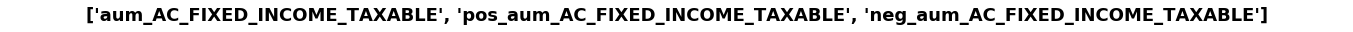

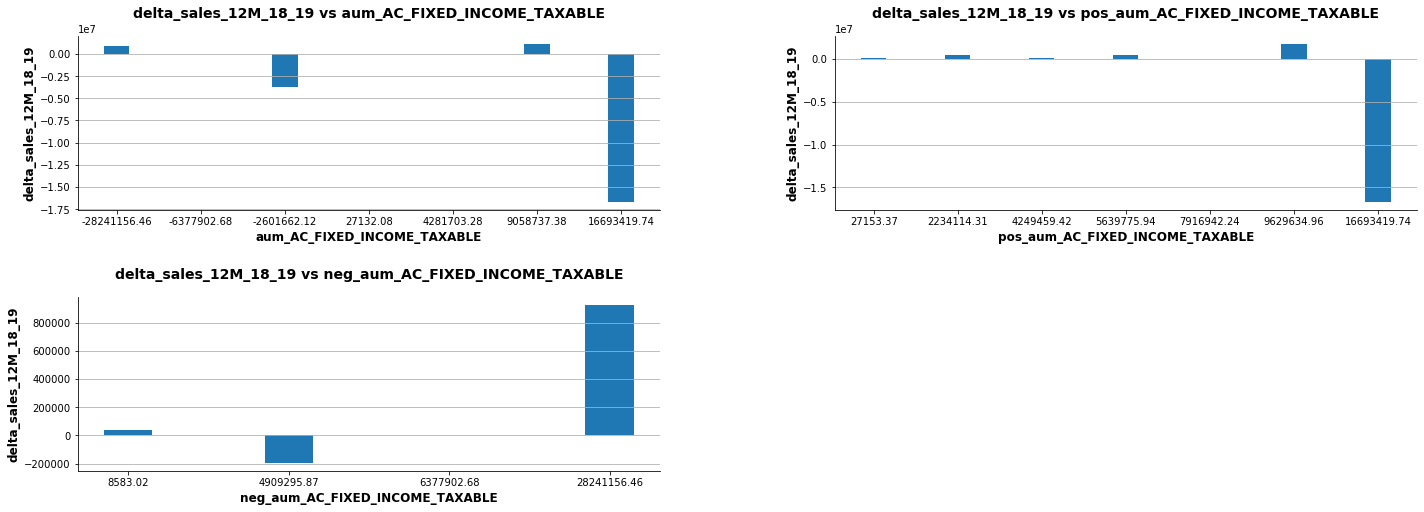

In [88]:
grd = ['aum_AC_FIXED_INCOME_TAXABLE', 'pos_aum_AC_FIXED_INCOME_TAXABLE', 'neg_aum_AC_FIXED_INCOME_TAXABLE']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data_raw, x=col, y='delta_sales_12M_18_19', ax=fig.add_subplot(gs[idx]))

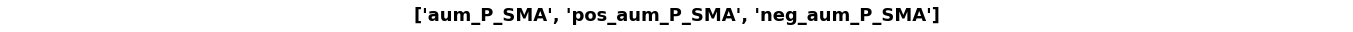

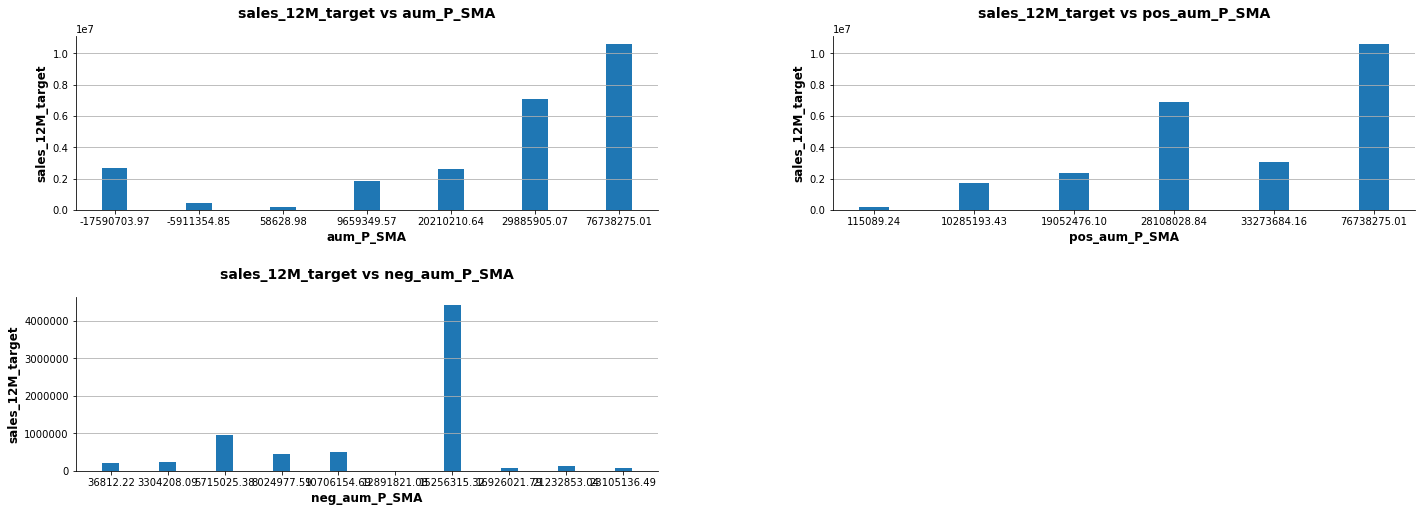

In [89]:
grd = ['aum_P_SMA','pos_aum_P_SMA','neg_aum_P_SMA']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data_raw, x=col, y='sales_12M_target', ax=fig.add_subplot(gs[idx]))

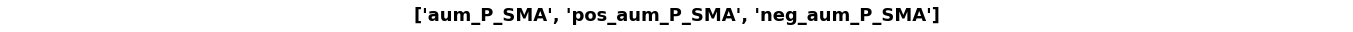

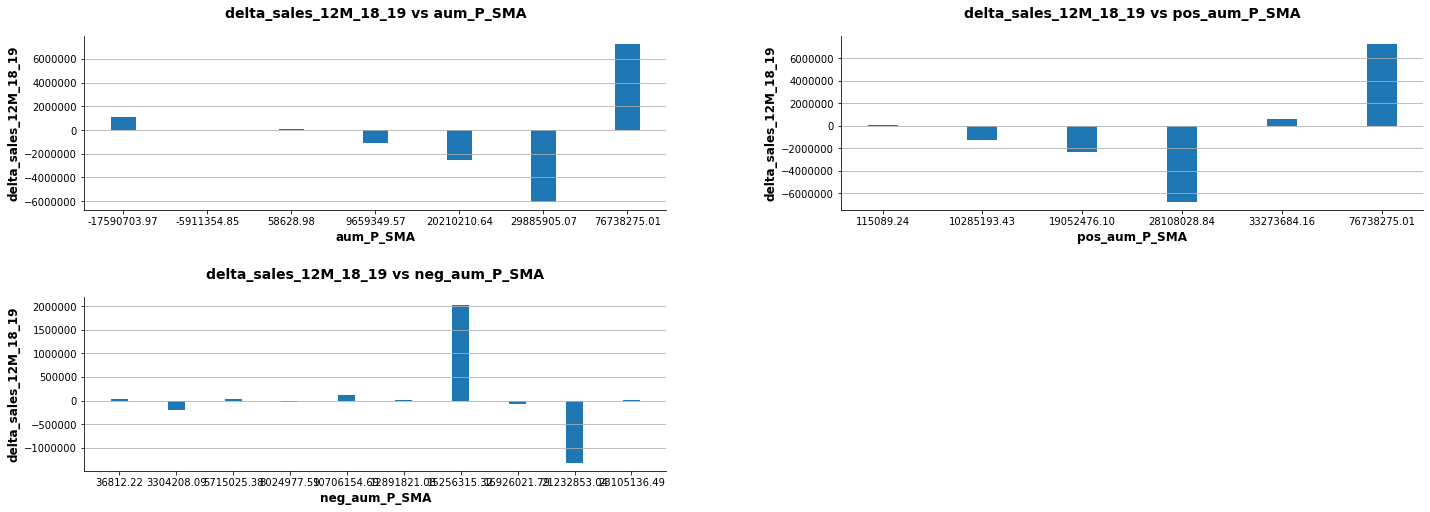

In [90]:
grd = ['aum_P_SMA','pos_aum_P_SMA','neg_aum_P_SMA']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data_raw, x=col, y='delta_sales_12M_18_19', ax=fig.add_subplot(gs[idx]))

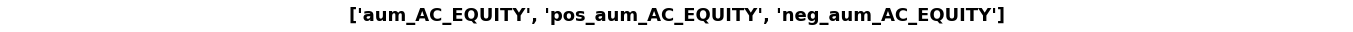

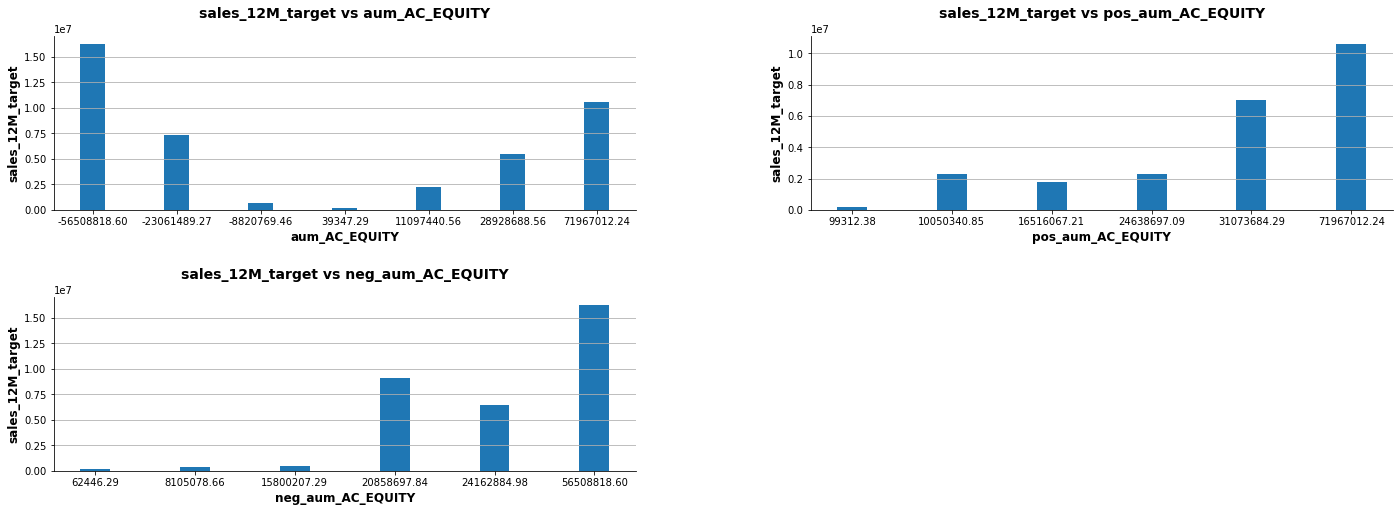

In [91]:
grd = ['aum_AC_EQUITY','pos_aum_AC_EQUITY','neg_aum_AC_EQUITY']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data_raw, x=col, y='sales_12M_target', ax=fig.add_subplot(gs[idx]))

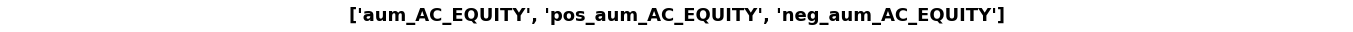

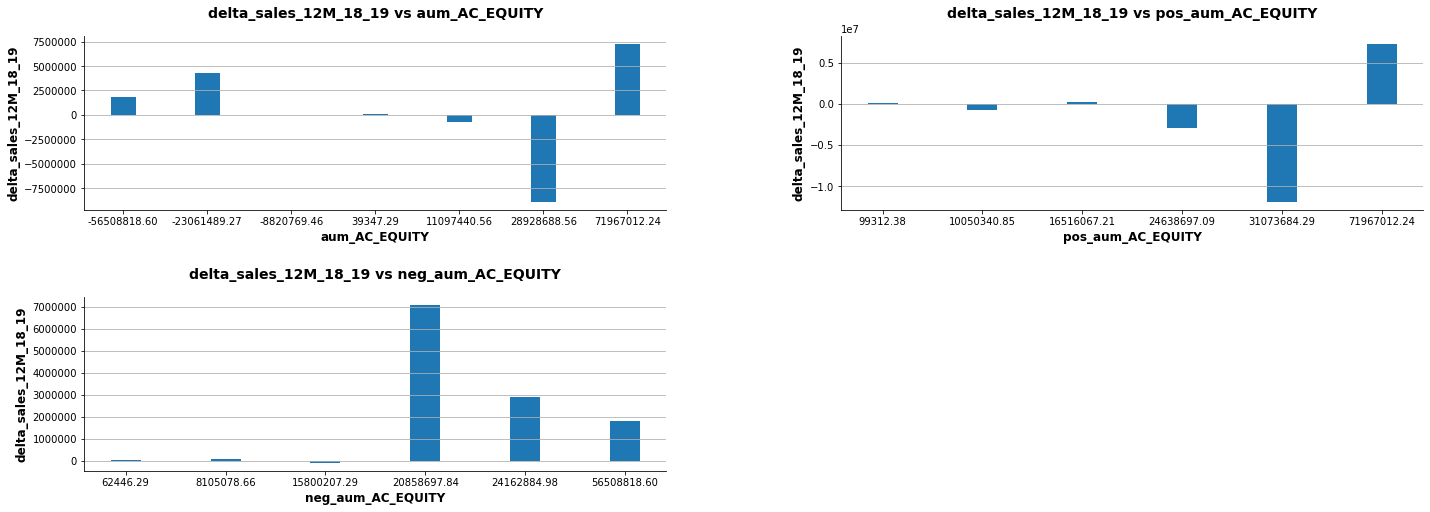

In [92]:
grd = ['aum_AC_EQUITY','pos_aum_AC_EQUITY','neg_aum_AC_EQUITY']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data_raw, x=col, y='delta_sales_12M_18_19', ax=fig.add_subplot(gs[idx]))

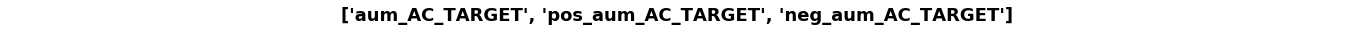

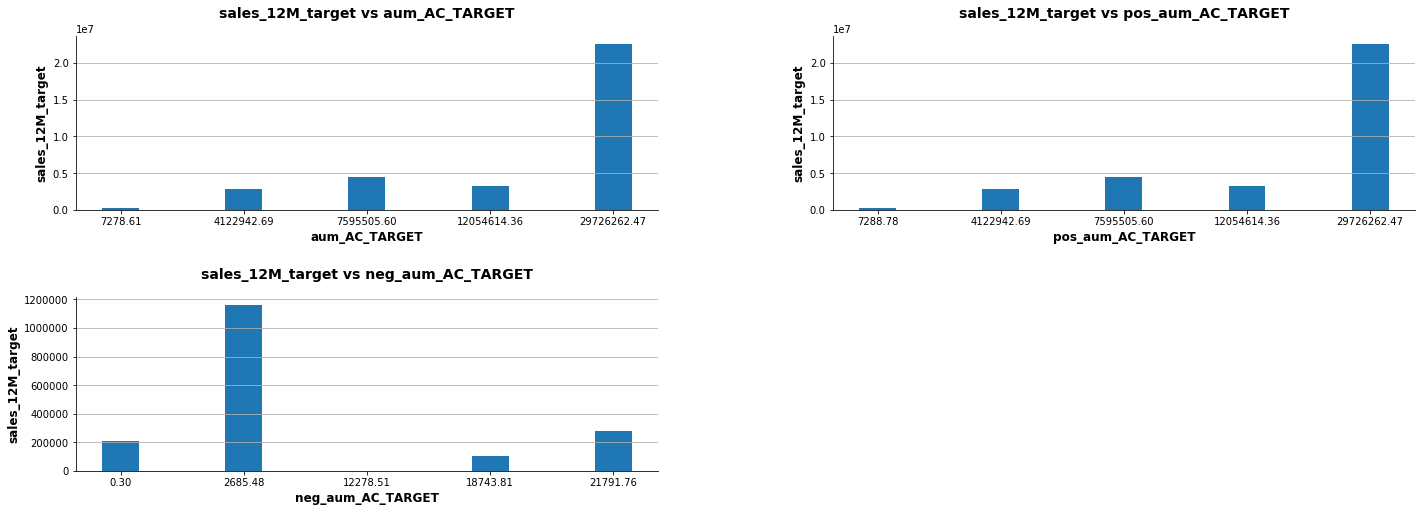

In [93]:
grd = ['aum_AC_TARGET','pos_aum_AC_TARGET','neg_aum_AC_TARGET']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data_raw, x=col, y='sales_12M_target', ax=fig.add_subplot(gs[idx]))

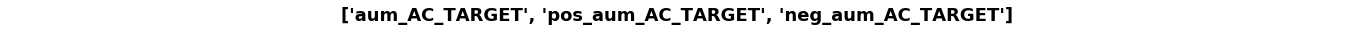

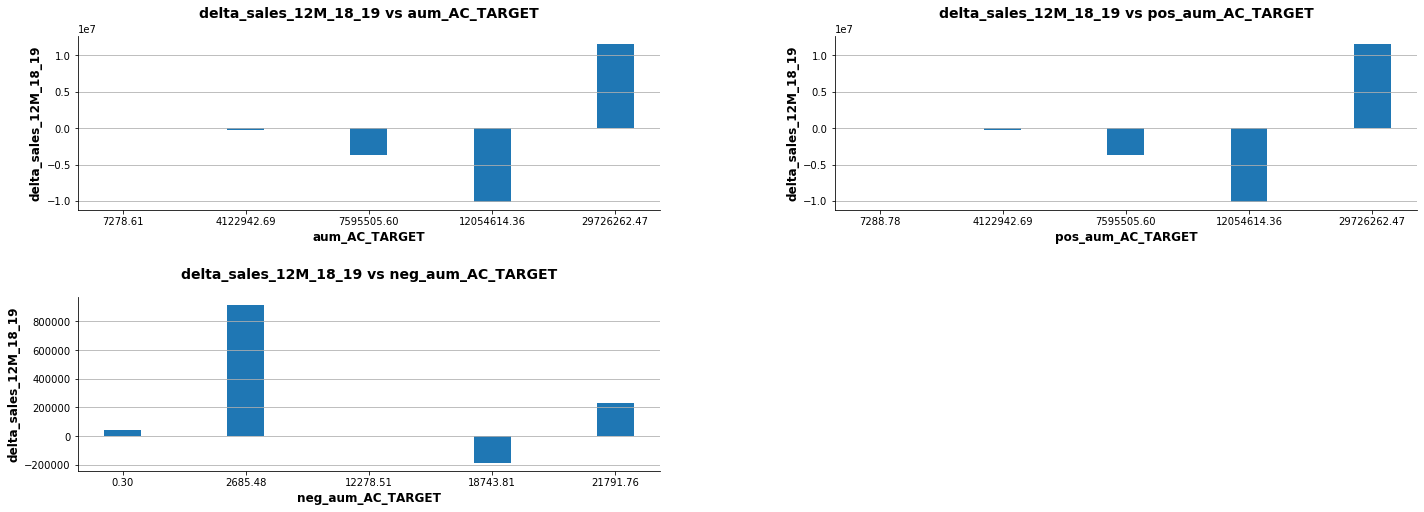

In [94]:
grd = ['aum_AC_TARGET','pos_aum_AC_TARGET','neg_aum_AC_TARGET']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data_raw, x=col, y='delta_sales_12M_18_19', ax=fig.add_subplot(gs[idx]))

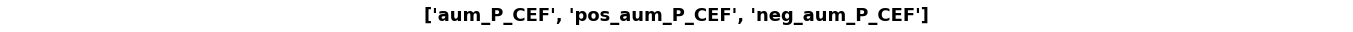

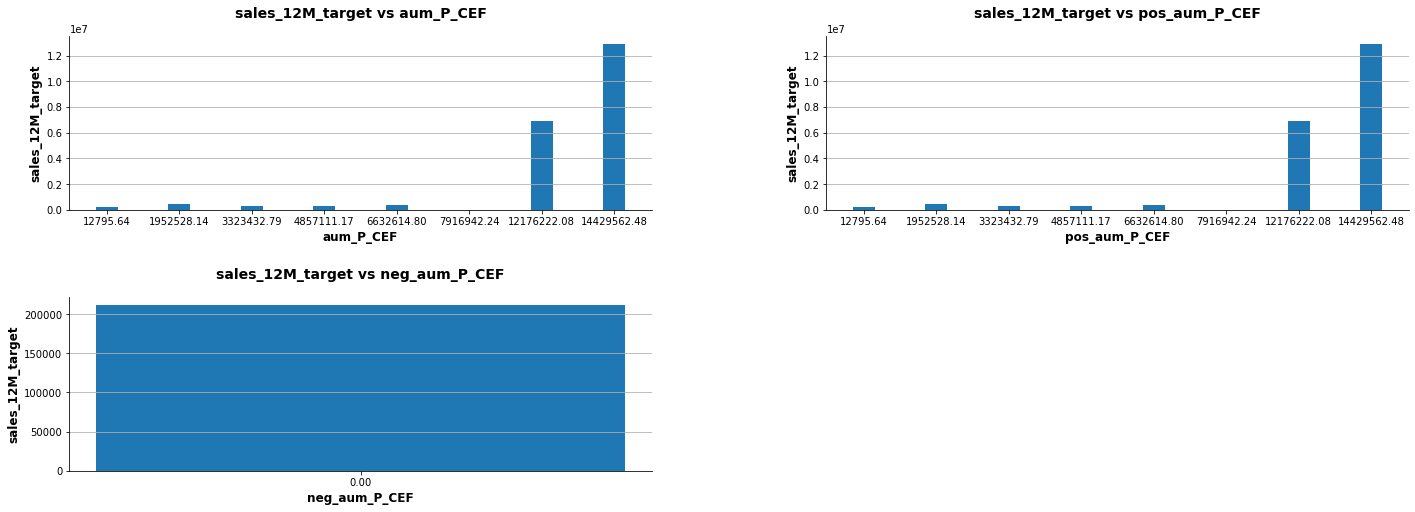

In [95]:
grd = ['aum_P_CEF','pos_aum_P_CEF','neg_aum_P_CEF']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data_raw, x=col, y='sales_12M_target', ax=fig.add_subplot(gs[idx]))

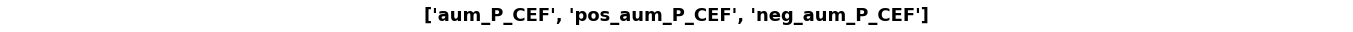

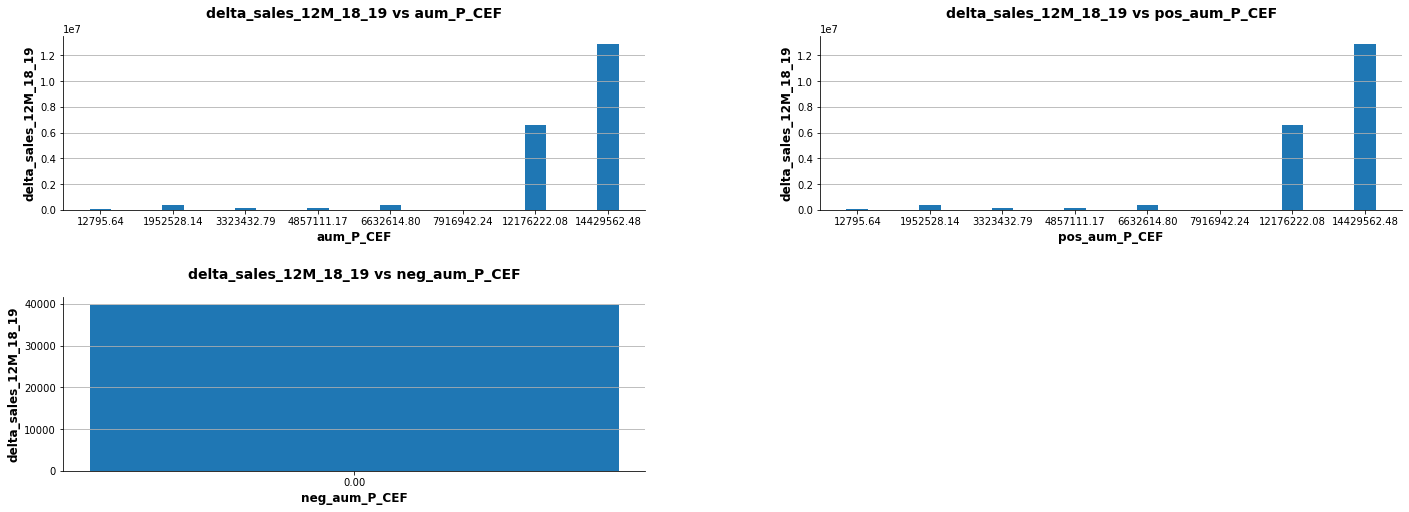

In [96]:
grd = ['aum_P_CEF','pos_aum_P_CEF','neg_aum_P_CEF']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data_raw, x=col, y='delta_sales_12M_18_19', ax=fig.add_subplot(gs[idx]))

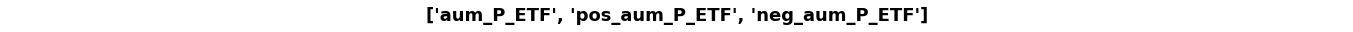

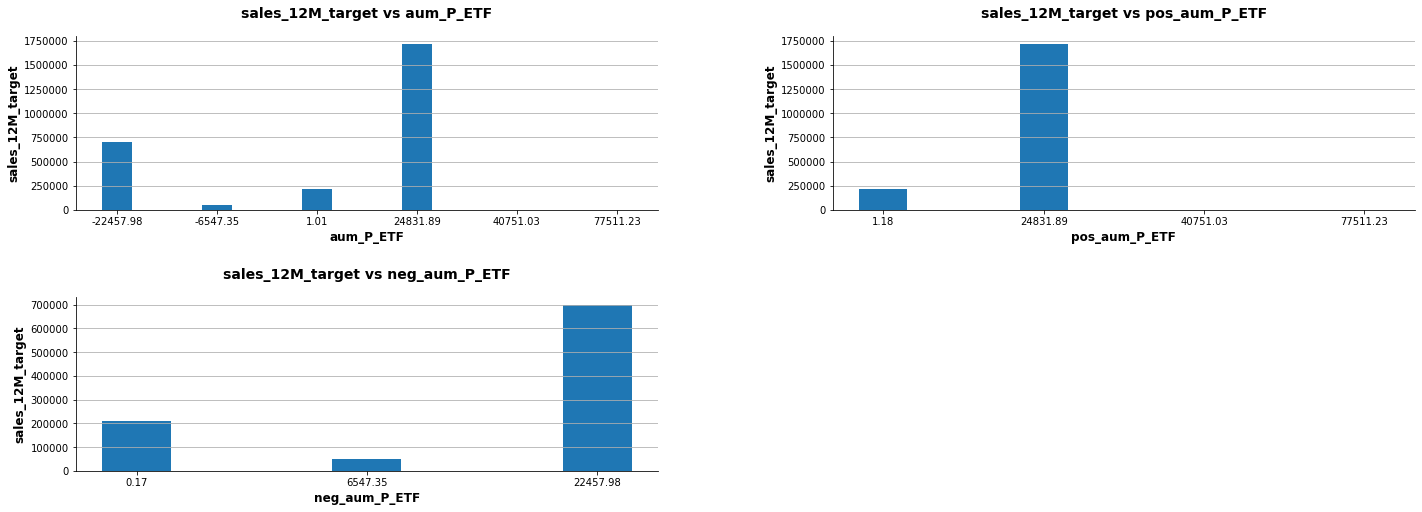

In [97]:
grd = ['aum_P_ETF','pos_aum_P_ETF','neg_aum_P_ETF']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data_raw, x=col, y='sales_12M_target', ax=fig.add_subplot(gs[idx]))

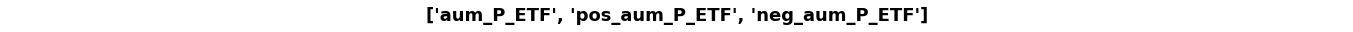

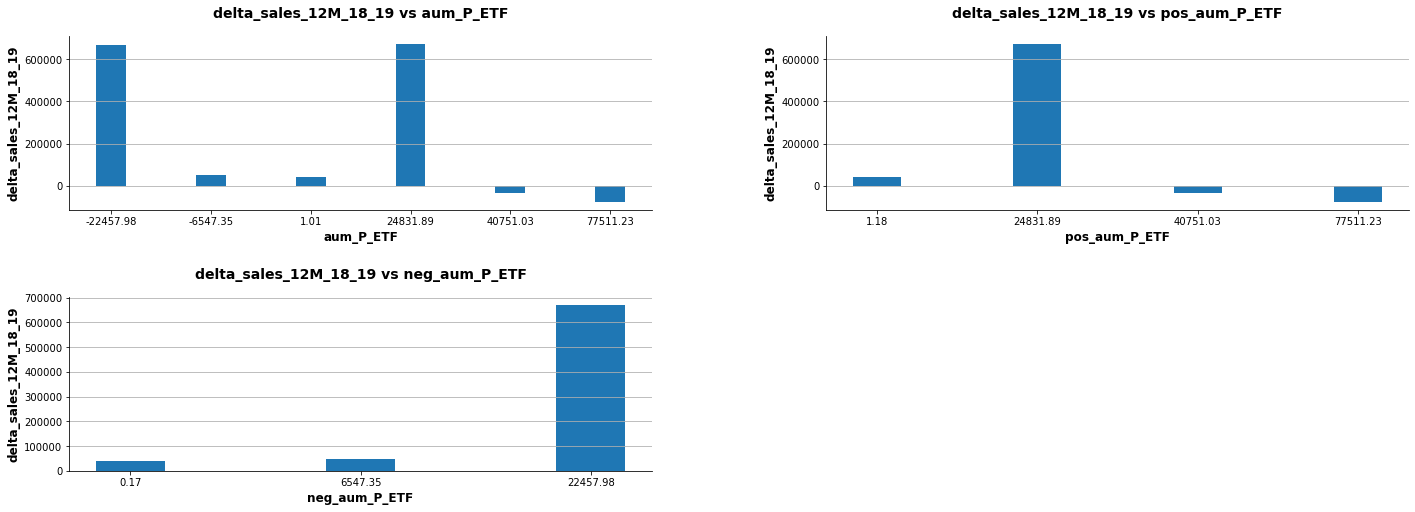

In [98]:
grd = ['aum_P_ETF','pos_aum_P_ETF','neg_aum_P_ETF']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data_raw, x=col, y='delta_sales_12M_18_19', ax=fig.add_subplot(gs[idx]))

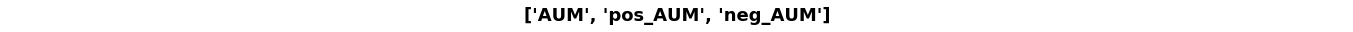

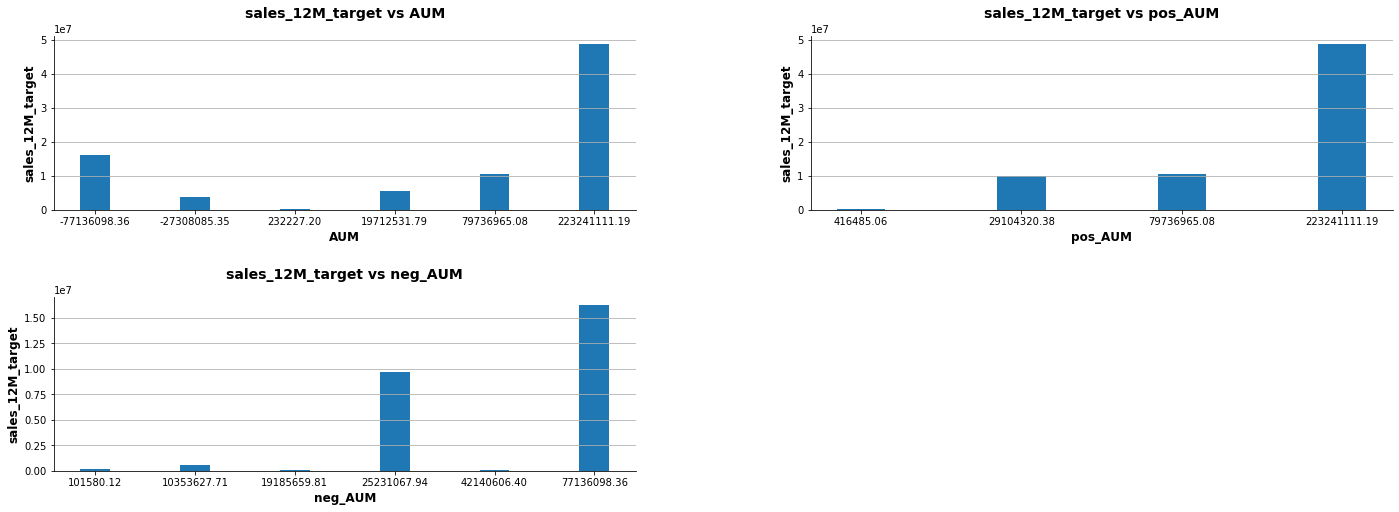

In [99]:
grd = ['AUM','pos_AUM','neg_AUM']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data_raw, x=col, y='sales_12M_target', ax=fig.add_subplot(gs[idx]))

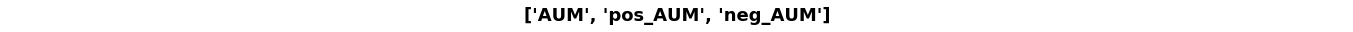

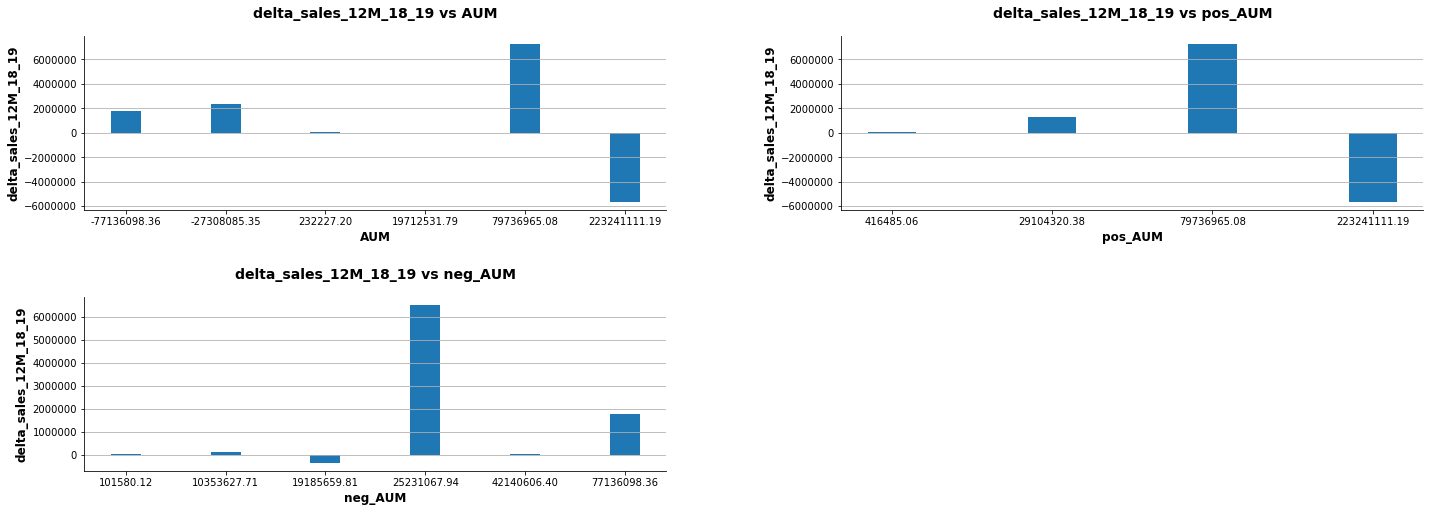

In [100]:
grd = ['AUM','pos_AUM','neg_AUM']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data_raw, x=col, y='delta_sales_12M_18_19', ax=fig.add_subplot(gs[idx]))

In [101]:
data2 = data_raw.copy()
data2['aum_sum'] = data2['aum_AC_FIXED_INCOME_TAXABLE'] + data2['aum_P_SMA'] + data2['aum_AC_EQUITY'] + data2['aum_AC_TARGET'] + data2['aum_P_CEF'] + data2['aum_P_ETF']
data2['pos_aum_sum'] = data2['pos_aum_AC_FIXED_INCOME_TAXABLE'] + data2['pos_aum_P_SMA'] + data2['pos_aum_AC_EQUITY'] + data2['pos_aum_AC_TARGET'] + data2['pos_aum_P_CEF'] + data2['pos_aum_P_ETF']
data2['neg_aum_sum'] = data2['neg_aum_AC_FIXED_INCOME_TAXABLE'] + data2['neg_aum_P_SMA'] + data2['neg_aum_AC_EQUITY'] + data2['neg_aum_AC_TARGET'] + data2['neg_aum_P_CEF'] + data2['neg_aum_P_ETF']

In [102]:
# data2 = data_raw.copy()
data2['aum_ac_sum'] = data2['aum_AC_FIXED_INCOME_TAXABLE'] + data2['aum_AC_EQUITY'] + data2['aum_AC_TARGET']
data2['pos_ac_aum_sum'] = data2['pos_aum_AC_FIXED_INCOME_TAXABLE'] + data2['pos_aum_AC_EQUITY'] + data2['pos_aum_AC_TARGET']
data2['neg_ac_aum_sum'] = data2['neg_aum_AC_FIXED_INCOME_TAXABLE'] + data2['neg_aum_AC_EQUITY'] + data2['neg_aum_AC_TARGET']

In [103]:
# data2 = data_raw.copy()
data2['aum_p_sum'] = data2['aum_P_SMA'] + data2['aum_P_CEF'] + data2['aum_P_ETF']
data2['pos_p_aum_sum'] = data2['pos_aum_P_SMA'] + data2['pos_aum_P_CEF'] + data2['pos_aum_P_ETF']
data2['neg_p_aum_sum'] = data2['neg_aum_P_SMA'] + data2['neg_aum_P_CEF'] + data2['neg_aum_P_ETF']

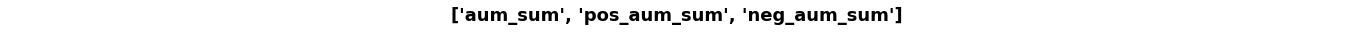

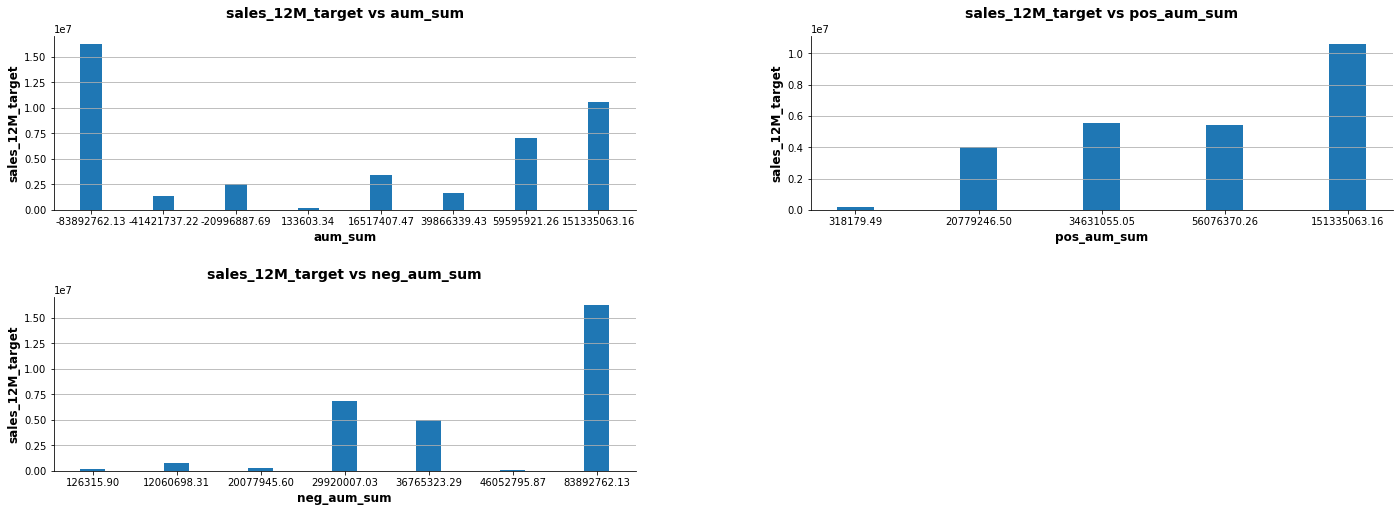

In [104]:
grd = ['aum_sum','pos_aum_sum','neg_aum_sum']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data2, x=col, y='sales_12M_target', ax=fig.add_subplot(gs[idx]))

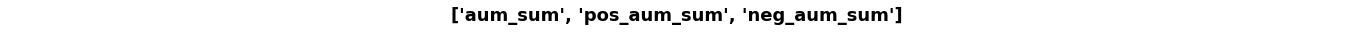

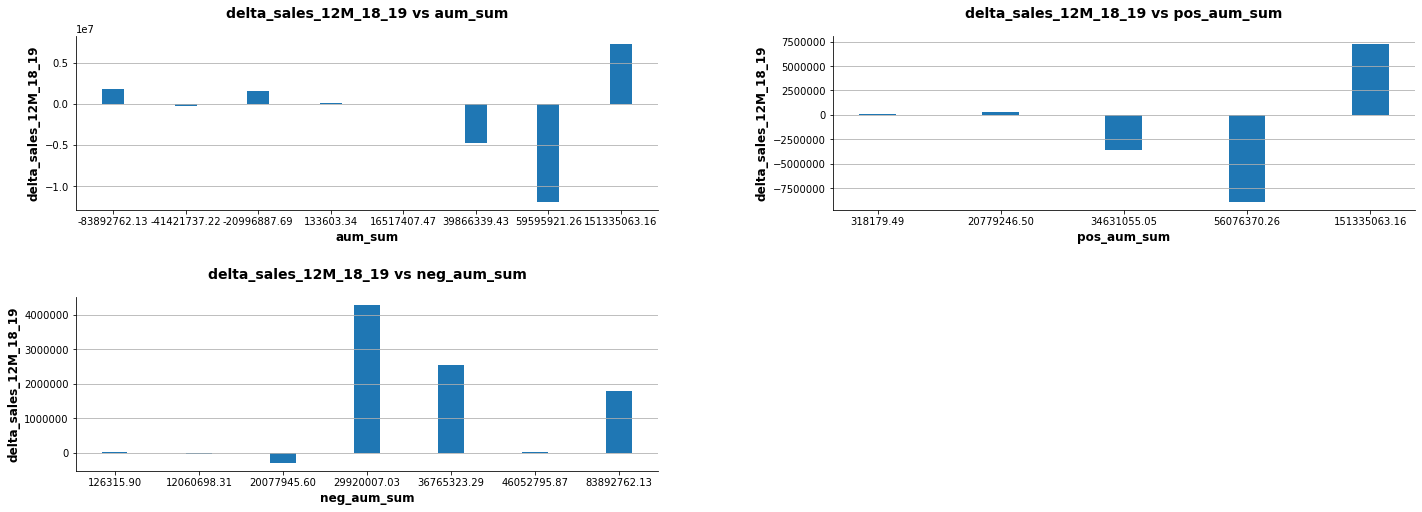

In [105]:
grd = ['aum_sum','pos_aum_sum','neg_aum_sum']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data2, x=col, y='delta_sales_12M_18_19', ax=fig.add_subplot(gs[idx]))

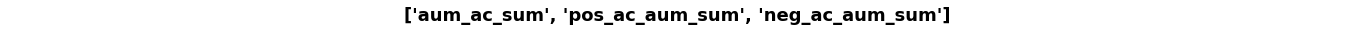

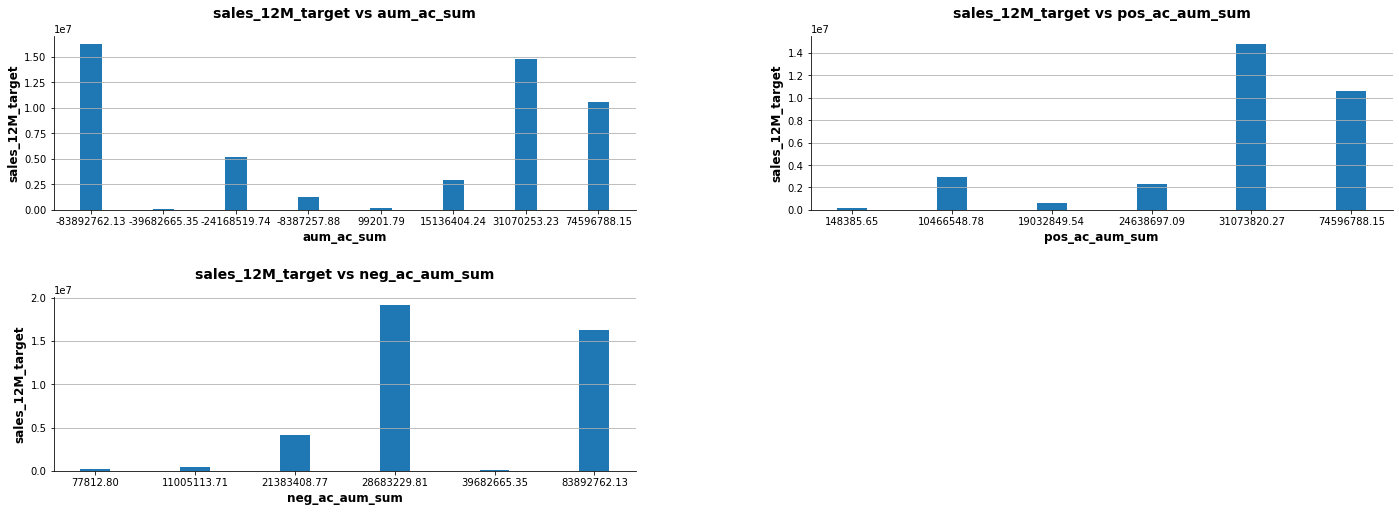

In [106]:
grd = ['aum_ac_sum','pos_ac_aum_sum','neg_ac_aum_sum']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data2, x=col, y='sales_12M_target', ax=fig.add_subplot(gs[idx]))

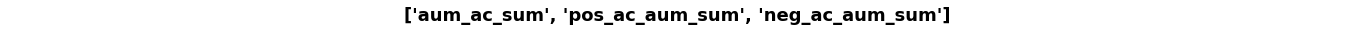

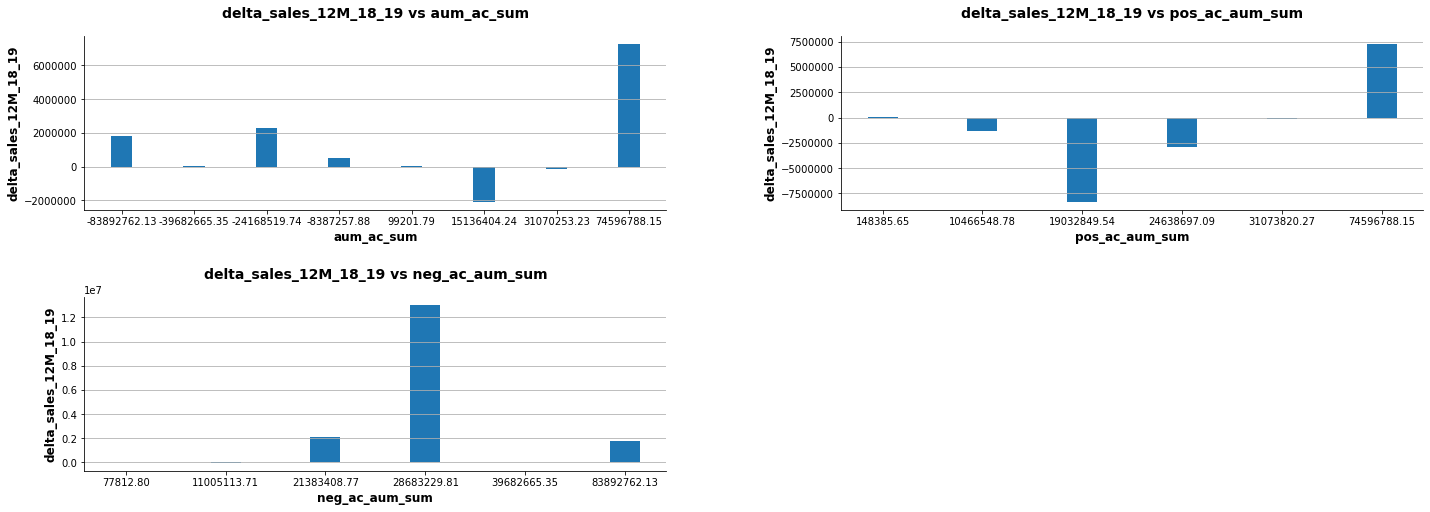

In [107]:
grd = ['aum_ac_sum','pos_ac_aum_sum','neg_ac_aum_sum']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data2, x=col, y='delta_sales_12M_18_19', ax=fig.add_subplot(gs[idx]))

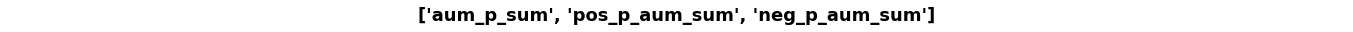

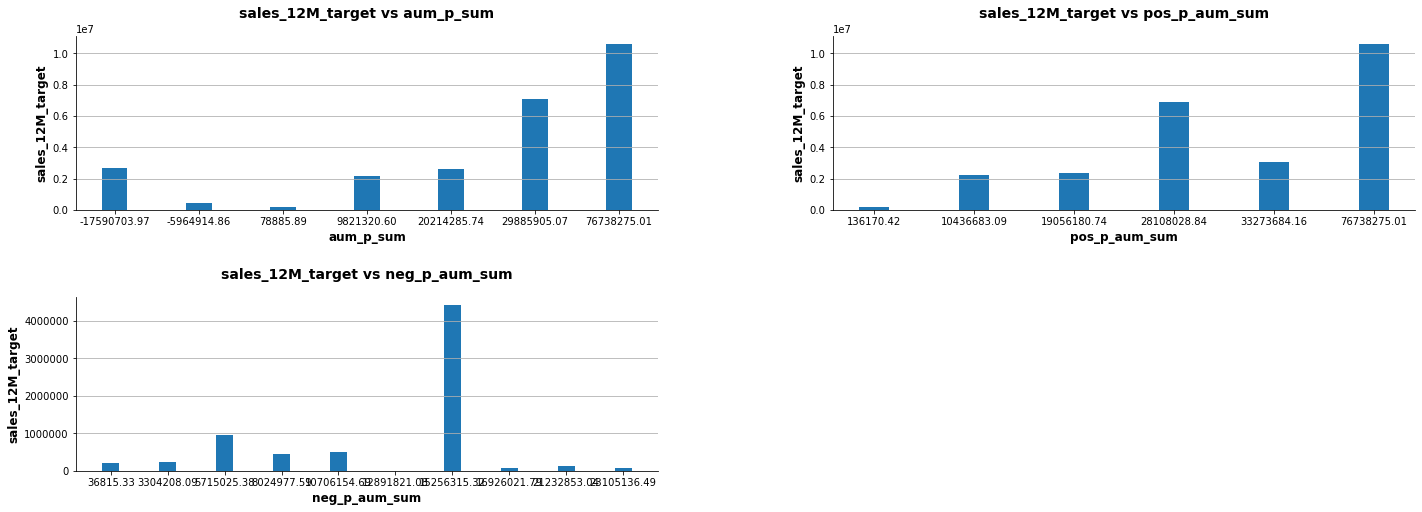

In [108]:
grd = ['aum_p_sum','pos_p_aum_sum','neg_p_aum_sum']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data2, x=col, y='sales_12M_target', ax=fig.add_subplot(gs[idx]))

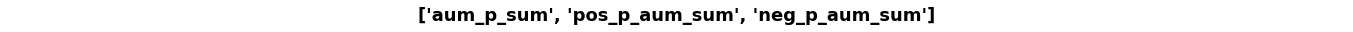

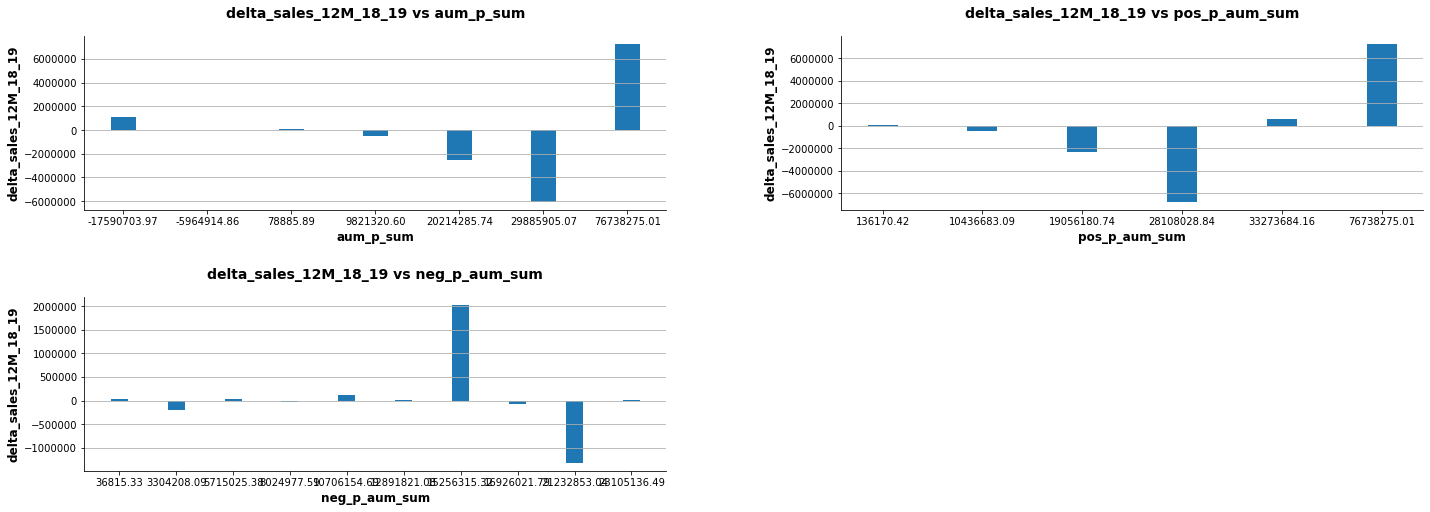

In [109]:
grd = ['aum_p_sum','pos_p_aum_sum','neg_p_aum_sum']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data2, x=col, y='delta_sales_12M_18_19', ax=fig.add_subplot(gs[idx]))

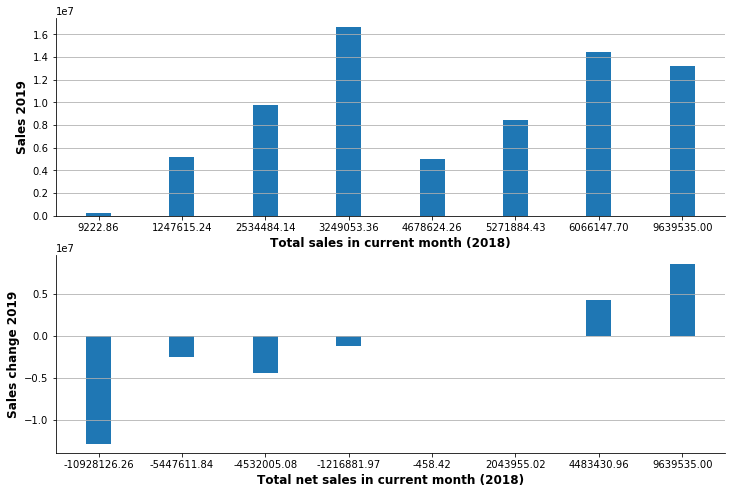

In [110]:
fig = plt.figure()
fig.set_size_inches(12, 8)

ax=fig.add_subplot(2,1,1)
plot_diagram_xy(data_raw, x='sales_curr', y='sales_12M_target', ax=ax, x_title='Total sales in current month (2018)', y_title='Sales 2019', title='')

ax=fig.add_subplot(2,1,2)
plot_diagram_xy(data_raw, x='net_sales_curr', y='delta_sales_12M_18_19', ax=ax, x_title='Total net sales in current month (2018)', y_title='Sales change 2019', title='')

plt.savefig('temp.jpg')

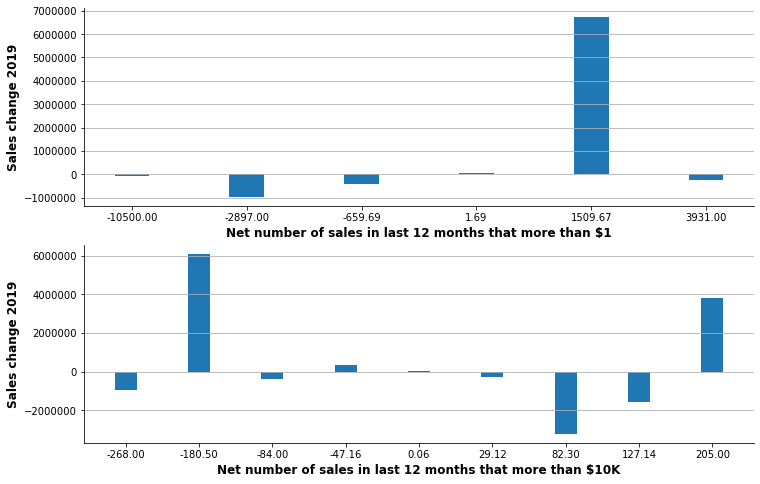

In [111]:
fig = plt.figure()
fig.set_size_inches(12, 8)

ax=fig.add_subplot(2,1,1)
plot_diagram_xy(data_raw, x='net_no_of_sales_12M_1', y='delta_sales_12M_18_19', ax=ax, 
                x_title='Net number of sales in last 12 months that more than $1', y_title='Sales change 2019', title='')

ax=fig.add_subplot(2,1,2)
plot_diagram_xy(data_raw, x='net_no_of_sales_12M_10K', y='delta_sales_12M_18_19', ax=ax, 
                x_title='Net number of sales in last 12 months that more than $10K', y_title='Sales change 2019', title='')

plt.savefig('temp.jpg')

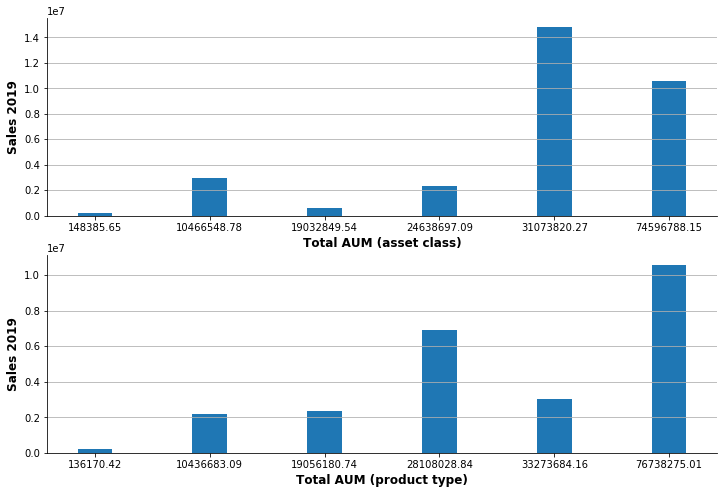

In [112]:
fig = plt.figure()
fig.set_size_inches(12, 8)

ax=fig.add_subplot(2,1,1)
plot_diagram_xy(data2, x='pos_ac_aum_sum', y='sales_12M_target', ax=ax, 
                x_title='Total AUM (asset class)', y_title='Sales 2019', title='')

ax=fig.add_subplot(2,1,2)
plot_diagram_xy(data2, x='pos_p_aum_sum', y='sales_12M_target', ax=ax, 
                x_title='Total AUM (product type)', y_title='Sales 2019', title='')

plt.savefig('temp.jpg')

#### Conclusions

1. Advisors that have higher sales in current month will likely have higher sales next year.
2. Advisors that have higher net sales in current month will likely increase sales next year and vice-versa.
3. Advisors that have positive net number of sales that are more than $1 in the last 12 months will likely increase their sales next year. But advisors with positive net number of sales that more than $10K in the last 12 months will likely decrease their sales next year.
4. Advisers with higher AUM will likely have higher sales next year.